#Permite chequear que los XMLs asociados a las imágenes no tengan errores y visualizar los box para comprobar que sean correctos:

# Preparación del entorno:

In [1]:
#@title Cargar Librerías
from IPython.display import Image, display
from PIL import Image as ImPIL
import numpy as np
import os
import cv2
import os.path
import datetime

import tensorflow as tf
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import xml.etree.cElementTree as ET

print ("Librerías cargadas.")

Librerías cargadas.


In [2]:
#@title Montar Drive
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Revisión de XMLs disponibles:

In [11]:
#@title Definir parámetros a utilizar

#@markdown Parámetros de Archivos:
levantarSoloDA =  False #param {type:"boolean"}
filtrar_prefijo_inicial_caso_generado = "" #@param {type:"string"}
drive_path = "/content/gdrive/MyDrive/IA/demoObjDet-Carteles-YOLO/Carteles/Generados" #@param {type:"string"}

#@markdown Parámetros sobre Controles:
revisarObjetosEncimados = True #@param {type:"boolean"}

#@markdown Parámetros sobre Información a Mostrar:
cantMuestraMostrar =  50#@param {type:"integer"}
mostrarImagenOriginal = False #@param {type:"boolean"}
extraerObjetos = False #@param {type:"boolean"}
mostrarObjetosEnImagen = True #@param {type:"boolean"}
calcularCantTipoObjetos =  True #@param {type:"boolean"}

print("Parámetros definidos.")


# definición de colores standard para clases
colors = [
      'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
      'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
      'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
      'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
      'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
      'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
      'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
      'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
      'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
      'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
      'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
      'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
      'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
      'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
      'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
      'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
      'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
      'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
      'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
      'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
      'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
      'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
      'WhiteSmoke', 'Yellow', 'YellowGreen'
  ]


print("Colores definidos: ", len(colors))

Parámetros definidos.
Colores definidos:  126


In [16]:
#@title Determinar XMLs a revisar
drive.mount('/content/gdrive', force_remount=True)

# define la carpeta donde están las imágenes para procesar
data_dir_path = drive_path
image_dir_path = data_dir_path

# levanta los XML  para procesar
all_xml_array = [ fn for fn in os.listdir( data_dir_path ) if fn.endswith('.xml')  ]
if levantarSoloDA and len(all_xml_array)>0:
  all_xml_array = [ fn for fn in all_xml_array if fn.startswith('da')  ]
if filtrar_prefijo_inicial_caso_generado != "" and len(all_xml_array)>0:
  all_xml_array = [ fn for fn in all_xml_array if fn.find('_'+ filtrar_prefijo_inicial_caso_generado +'_')>0 ]

# desordena y toma algunos al azar
if len(all_xml_array)>cantMuestraMostrar:
  np.random.shuffle(all_xml_array)
  mostrar_xml_array, _ = np.split(np.array(all_xml_array), [cantMuestraMostrar])
else:
  mostrar_xml_array = np.array(all_xml_array)

print("> XML a probar: ", len(all_xml_array))
print("> XML a mostrar: ", len(mostrar_xml_array))

if len(mostrar_xml_array) > 0:
  fechasCreacion = [ datetime.datetime.fromtimestamp(os.path.getmtime(data_dir_path + '/' + ar)) for ar in mostrar_xml_array]
  print("> Fechas de creación de XML a mostrar entre ",   min( fechasCreacion ), " y ", max( fechasCreacion ))


Mounted at /content/gdrive
> XML a probar:  1000
> XML a mostrar:  50
> Fechas de creación de XML a mostrar entre  2025-09-30 15:55:44  y  2025-09-30 15:58:06




 1 >  cartel_000917760189921.xml


 2 >  cartel_001964123075405.xml


 3 >  cartel_003355452770067.xml


 4 >  cartel_003596492271406.xml


 5 >  cartel_003728325944542.xml


 6 >  cartel_003916246018152.xml


 7 >  cartel_004019053783519.xml




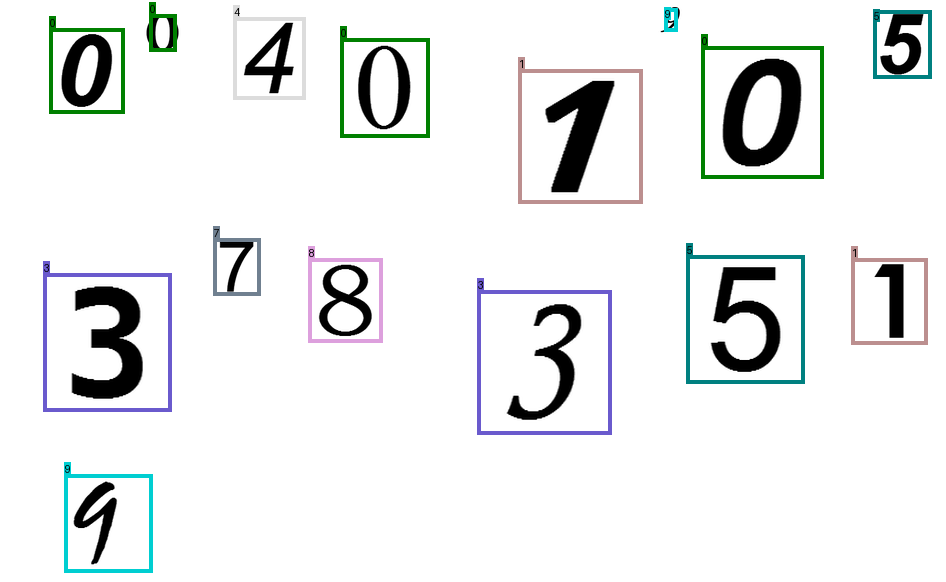



 8 >  cartel_004418756126305.xml


 9 >  cartel_005117164498553.xml


 10 >  cartel_007127771651322.xml


 11 >  cartel_009615243843345.xml


 12 >  cartel_009916197418051.xml


 13 >  cartel_010067842861715.xml


 14 >  cartel_010515471561670.xml


 15 >  cartel_012710989913354.xml


 16 >  cartel_013494392225351.xml


 17 >  cartel_014886597823198.xml


 18 >  cartel_015233337695942.xml


 19 >  cartel_015830970701524.xml


 20 >  cartel_017715725397171.xml


 21 >  cartel_019136307865926.xml


 22 >  cartel_019204553375433.xml


 23 >  cartel_019535670337220.xml


 24 >  cartel_020681281331325.xml


 25 >  cartel_022832704027487.xml


 26 >  cartel_023738295649982.xml


 27 >  cartel_024000424628152.xml


 28 >  cartel_024448278335561.xml


 29 >  cartel_025183071310544.xml


 30 >  cartel_026535631076289.xml


 31 >  cartel_026990364486562.xml


 32 >  cartel_029443654720022.xml


 33 >  cartel_029460319856046.xml


 34 >  cartel_030468687869786.xml


 35 >  cartel_03073421050643

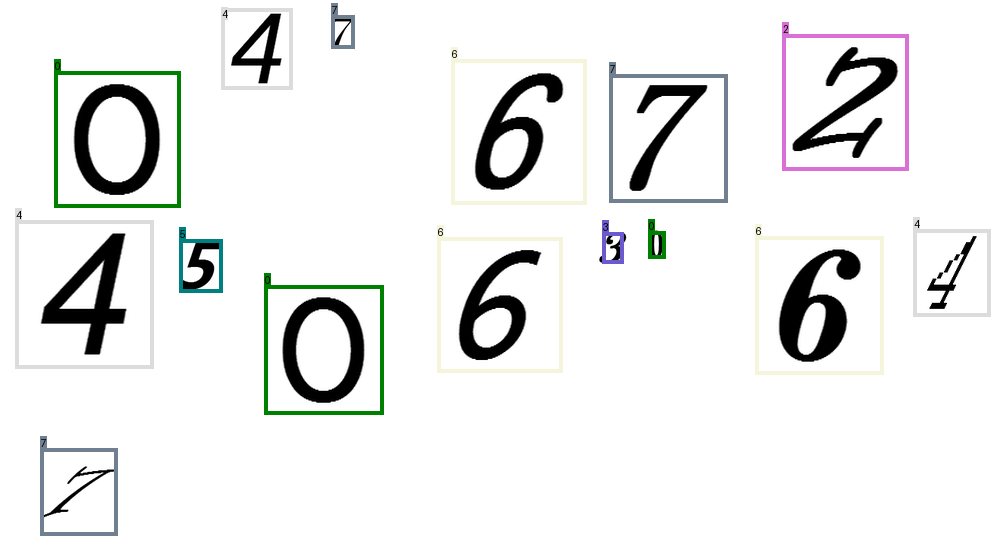



 58 >  cartel_050472704434830.xml


 59 >  cartel_051507430907887.xml


 60 >  cartel_053448914168434.xml


 61 >  cartel_053835809815111.xml


 62 >  cartel_054777903979373.xml


 63 >  cartel_054847256749837.xml


 64 >  cartel_057747656821708.xml


 65 >  cartel_058413282690491.xml


 66 >  cartel_059009691359581.xml


 67 >  cartel_059387171961202.xml


 68 >  cartel_059441818765176.xml


 69 >  cartel_059518688891704.xml


 70 >  cartel_059524980195024.xml


 71 >  cartel_059740725811881.xml


 72 >  cartel_062125712272048.xml


 73 >  cartel_063894512211625.xml


 74 >  cartel_065243830237371.xml


 75 >  cartel_065335963686152.xml


 76 >  cartel_065913620496555.xml


 77 >  cartel_066755357591659.xml


 78 >  cartel_068079499945997.xml


 79 >  cartel_069057766147654.xml


 80 >  cartel_069983529020509.xml


 81 >  cartel_070402779256953.xml


 82 >  cartel_075502506087774.xml


 83 >  cartel_076835682070443.xml


 84 >  cartel_076973505926210.xml


 85 >  cartel_078589834672

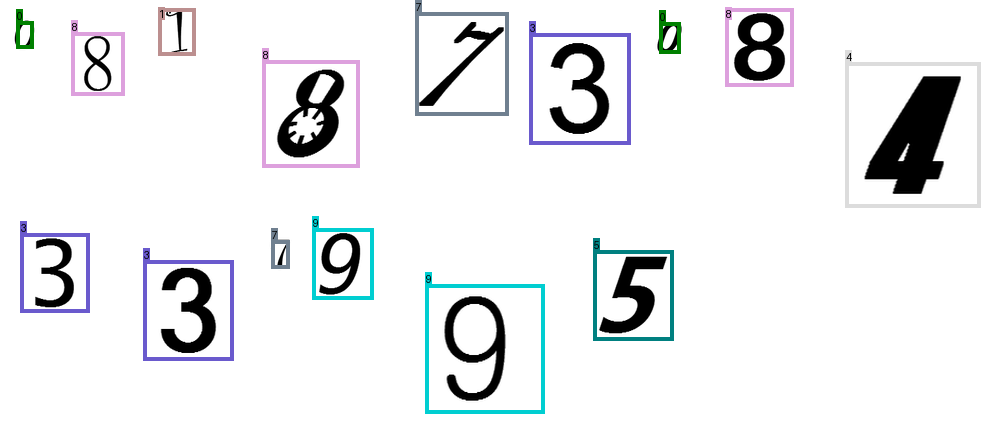



 94 >  cartel_083352467491151.xml


 95 >  cartel_083960595993127.xml


 96 >  cartel_086801031844537.xml


 97 >  cartel_086825284801048.xml


 98 >  cartel_087789408581960.xml


 99 >  cartel_088775964718907.xml


 100 >  cartel_090952620561586.xml


 101 >  cartel_091055619157331.xml


 102 >  cartel_093126174634576.xml


 103 >  cartel_094464499774342.xml


 104 >  cartel_094506354083274.xml


 105 >  cartel_095782645233295.xml


 106 >  cartel_099397335660485.xml


 107 >  cartel_101693347696289.xml


 108 >  cartel_102188865635622.xml


 109 >  cartel_103989006215980.xml


 110 >  cartel_105810311539075.xml


 111 >  cartel_106545778855156.xml


 112 >  cartel_106936539958587.xml


 113 >  cartel_107247272302807.xml


 114 >  cartel_107437819064396.xml


 115 >  cartel_108599210595280.xml


 116 >  cartel_109702725221714.xml


 117 >  cartel_112007276393085.xml


 118 >  cartel_112837548595058.xml


 119 >  cartel_114339051266458.xml


 120 >  cartel_114619363090724.xml




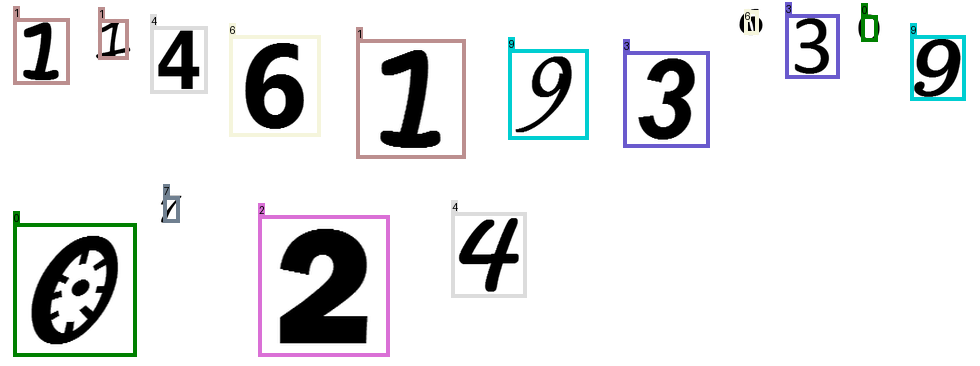



 121 >  cartel_115169017234407.xml


 122 >  cartel_116317970021084.xml


 123 >  cartel_116610141805879.xml


 124 >  cartel_117868303592351.xml


 125 >  cartel_117925725515088.xml


 126 >  cartel_119094500719746.xml


 127 >  cartel_119250173498703.xml


 128 >  cartel_119728214428497.xml


 129 >  cartel_120668659343231.xml


 130 >  cartel_121031188668892.xml


 131 >  cartel_121263146597126.xml


 132 >  cartel_123554192465906.xml


 133 >  cartel_126740735453979.xml


 134 >  cartel_126837285225224.xml




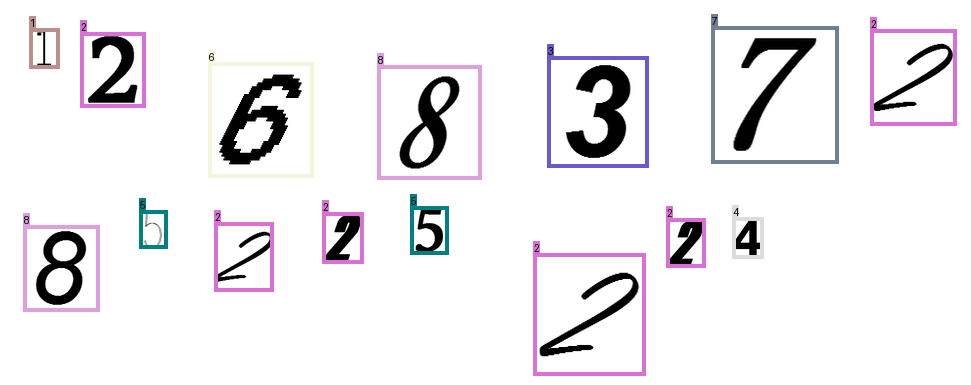



 135 >  cartel_128399191560239.xml


 136 >  cartel_128728240556807.xml


 137 >  cartel_129289596705654.xml


 138 >  cartel_129593623583576.xml


 139 >  cartel_131848757974730.xml


 140 >  cartel_135110586420955.xml


 141 >  cartel_135360959913465.xml


 142 >  cartel_136249892487861.xml




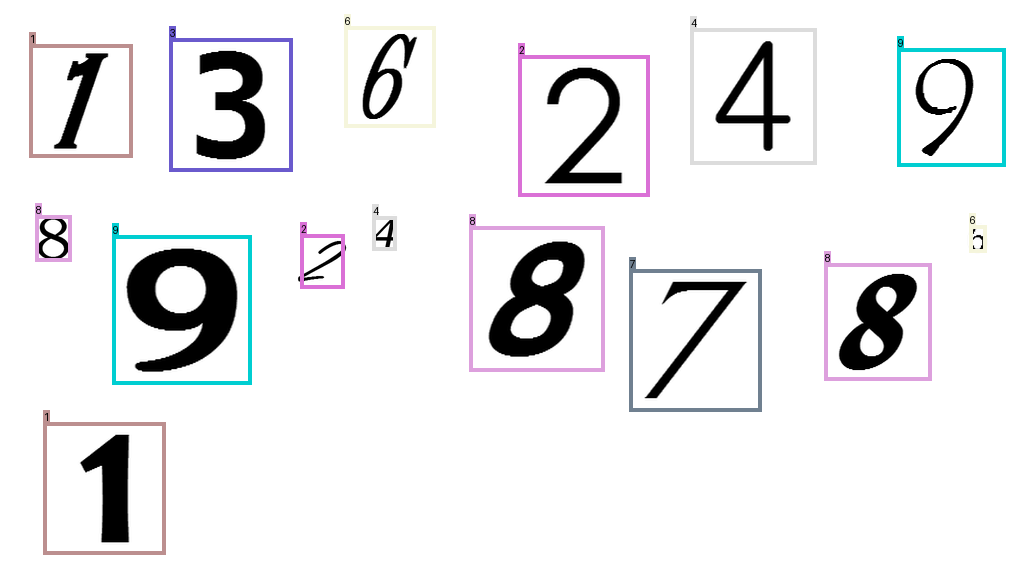



 143 >  cartel_136935801579692.xml


 144 >  cartel_137325904513050.xml


 145 >  cartel_138208221340342.xml


 146 >  cartel_138438770105829.xml


 147 >  cartel_138711742709816.xml


 148 >  cartel_139052543162009.xml


 149 >  cartel_139065865753842.xml


 150 >  cartel_139558195780743.xml


 151 >  cartel_140000197285897.xml


 152 >  cartel_142924655052617.xml


 153 >  cartel_143514636918073.xml


 154 >  cartel_143930008224016.xml


 155 >  cartel_144447363106365.xml


 156 >  cartel_145090688938613.xml


 157 >  cartel_146163882942496.xml


 158 >  cartel_146848612815934.xml


 159 >  cartel_146885904382878.xml


 160 >  cartel_147293852281541.xml


 161 >  cartel_147370411326024.xml


 162 >  cartel_148003961546218.xml


 163 >  cartel_148341294471152.xml


 164 >  cartel_148715880114444.xml


 165 >  cartel_148775650390592.xml


 166 >  cartel_149028267016911.xml


 167 >  cartel_149582444179323.xml


 168 >  cartel_149708641055121.xml


 169 >  cartel_150032405643106.xml



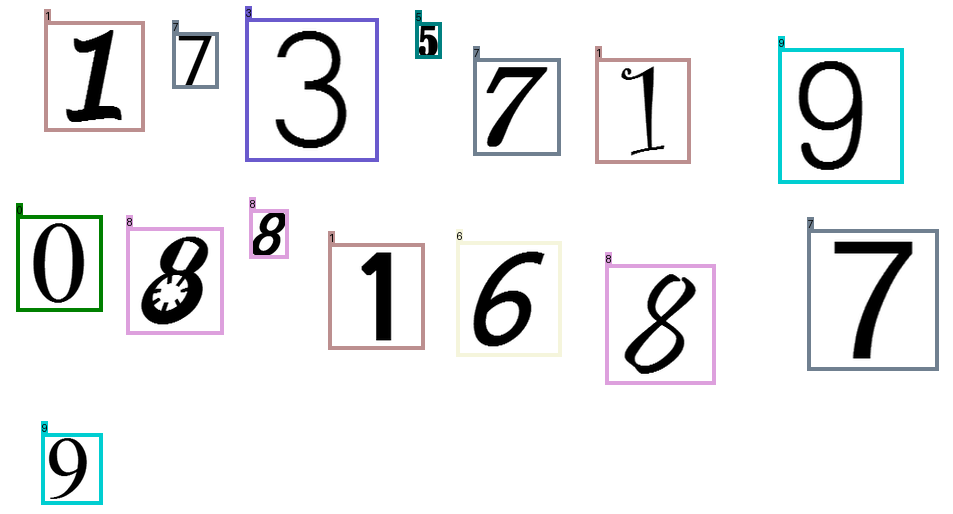



 188 >  cartel_175525882114838.xml




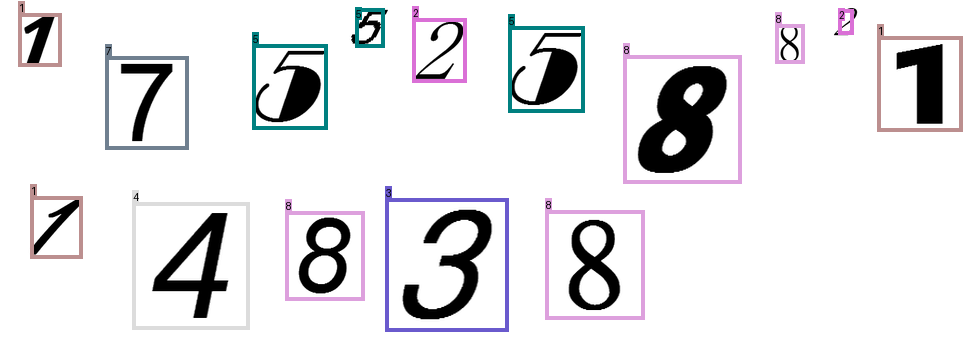



 189 >  cartel_176234360143551.xml


 190 >  cartel_177548044365965.xml


 191 >  cartel_179069022181318.xml


 192 >  cartel_181652763535829.xml


 193 >  cartel_183313537480188.xml


 194 >  cartel_184597259816274.xml


 195 >  cartel_184955464435438.xml


 196 >  cartel_190573418188611.xml


 197 >  cartel_194374629013909.xml


 198 >  cartel_196647898197371.xml


 199 >  cartel_197584181448204.xml


 200 >  cartel_197690432562286.xml


 201 >  cartel_199120478578535.xml


 202 >  cartel_199320756277950.xml


 203 >  cartel_200946662856320.xml


 204 >  cartel_201253048968672.xml


 205 >  cartel_204376550383848.xml


 206 >  cartel_204779648663403.xml


 207 >  cartel_206619673339680.xml


 208 >  cartel_206771338908807.xml


 209 >  cartel_206796586069936.xml


 210 >  cartel_207898934614887.xml


 211 >  cartel_208244247128402.xml


 212 >  cartel_208643417977990.xml


 213 >  cartel_210509770569039.xml


 214 >  cartel_212435576859066.xml


 215 >  cartel_213634983392523.xml



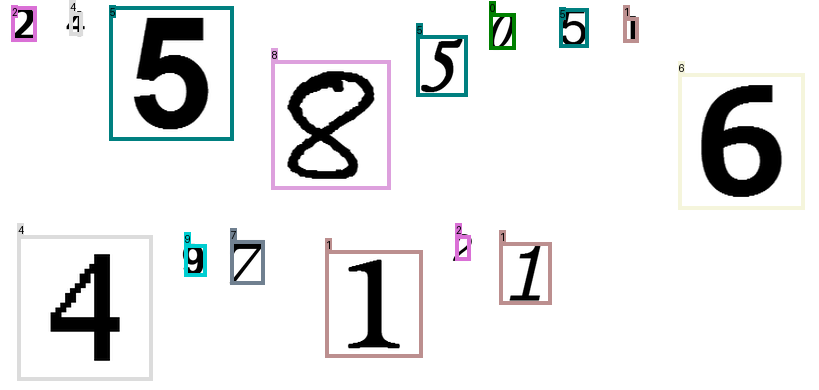



 246 >  cartel_246007027686825.xml


 247 >  cartel_246570658672080.xml


 248 >  cartel_246611210233699.xml


 249 >  cartel_247130848900433.xml


 250 >  cartel_247637118479042.xml


 251 >  cartel_247670655388261.xml


 252 >  cartel_248508118360693.xml


 253 >  cartel_248560815597196.xml


 254 >  cartel_249305196074678.xml


 255 >  cartel_250470967561209.xml


 256 >  cartel_251978007576786.xml


 257 >  cartel_252071382469835.xml


 258 >  cartel_253987085567476.xml


 259 >  cartel_255078672652823.xml


 260 >  cartel_255678167549851.xml


 261 >  cartel_257124628171141.xml


 262 >  cartel_257391959791855.xml




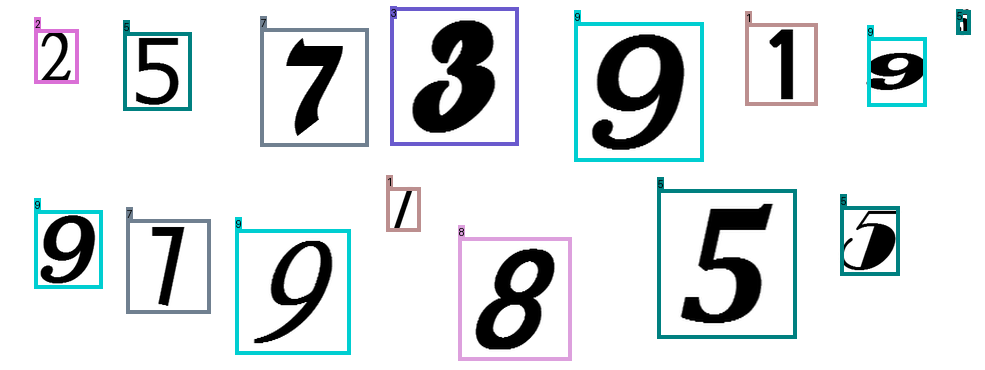



 263 >  cartel_258515482724398.xml


 264 >  cartel_260243792917043.xml


 265 >  cartel_260515832392625.xml


 266 >  cartel_260631136471287.xml


 267 >  cartel_260666494479452.xml


 268 >  cartel_261521618097154.xml


 269 >  cartel_261650949375000.xml


 270 >  cartel_262427424943800.xml


 271 >  cartel_263137135628741.xml




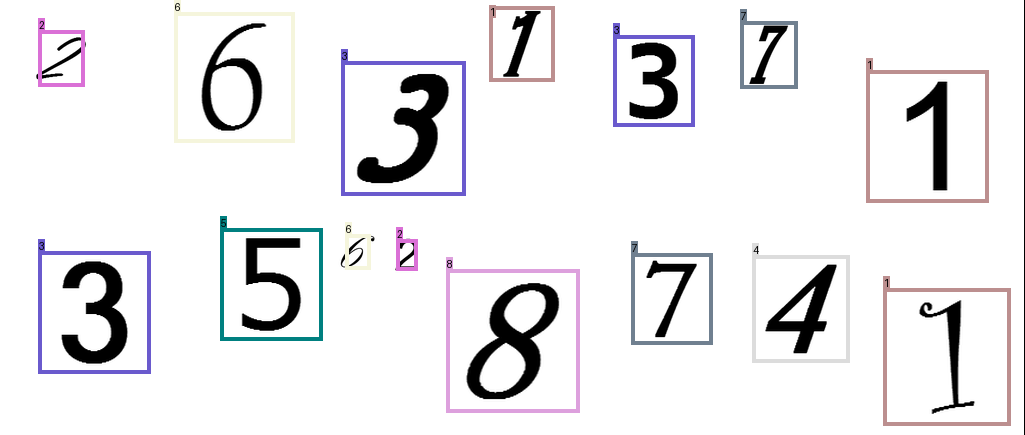



 272 >  cartel_263491087684893.xml


 273 >  cartel_265854829103749.xml


 274 >  cartel_266502933127066.xml


 275 >  cartel_266934625538663.xml


 276 >  cartel_267981001792693.xml


 277 >  cartel_269248004742566.xml


 278 >  cartel_269432304007181.xml


 279 >  cartel_270226136896056.xml


 280 >  cartel_271553805877002.xml


 281 >  cartel_271754535655108.xml


 282 >  cartel_274808232588078.xml


 283 >  cartel_275306620407785.xml


 284 >  cartel_275942563827207.xml


 285 >  cartel_276571815431077.xml


 286 >  cartel_277845091015320.xml


 287 >  cartel_278309115823073.xml


 288 >  cartel_280074846799546.xml


 289 >  cartel_280811330787330.xml




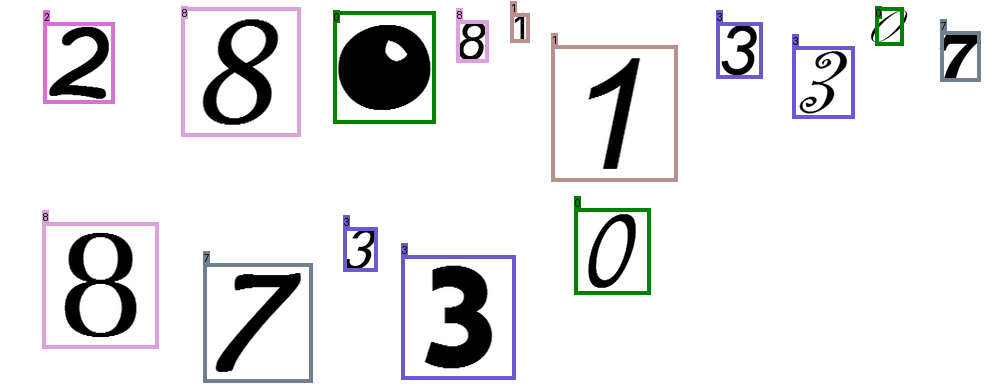



 290 >  cartel_282069803144885.xml


 291 >  cartel_283082733621930.xml


 292 >  cartel_283475135462054.xml


 293 >  cartel_283698074197948.xml


 294 >  cartel_283952303834720.xml


 295 >  cartel_283965273354491.xml


 296 >  cartel_284787509585379.xml


 297 >  cartel_285578964945009.xml


 298 >  cartel_285957101552237.xml


 299 >  cartel_286838630066401.xml


 300 >  cartel_289701292113164.xml


 301 >  cartel_289848622211065.xml




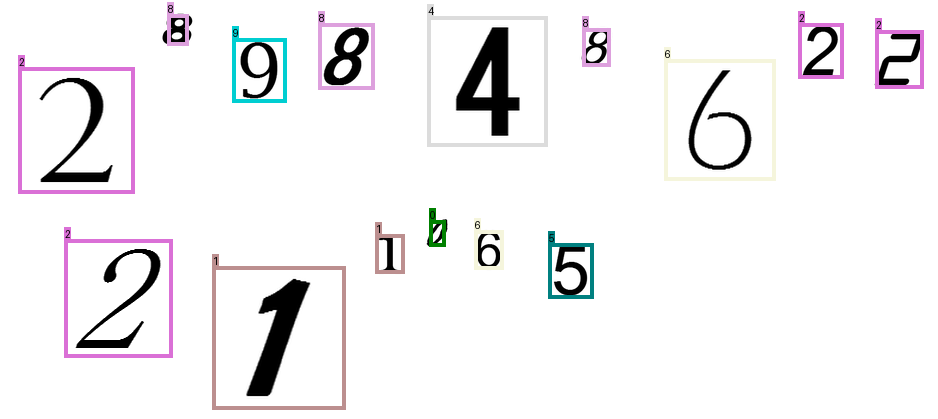



 302 >  cartel_290136085344648.xml


 303 >  cartel_291043332235750.xml


 304 >  cartel_291356911050489.xml


 305 >  cartel_295401911295055.xml


 306 >  cartel_297710372965701.xml


 307 >  cartel_299547438470192.xml


 308 >  cartel_301037338877942.xml


 309 >  cartel_301246370340430.xml


 310 >  cartel_301735796466353.xml


 311 >  cartel_302036846342390.xml


 312 >  cartel_302472342307194.xml


 313 >  cartel_305982162453729.xml


 314 >  cartel_306697496134767.xml


 315 >  cartel_307837103410735.xml


 316 >  cartel_310117604345963.xml


 317 >  cartel_310402388446078.xml


 318 >  cartel_310485707818055.xml


 319 >  cartel_310518065929004.xml


 320 >  cartel_312990866759287.xml


 321 >  cartel_313325789965419.xml


 322 >  cartel_314739524693745.xml


 323 >  cartel_315457843098298.xml


 324 >  cartel_316141670057189.xml


 325 >  cartel_316770875472462.xml


 326 >  cartel_317496327606746.xml


 327 >  cartel_319240992471519.xml


 328 >  cartel_321505152614267.xml



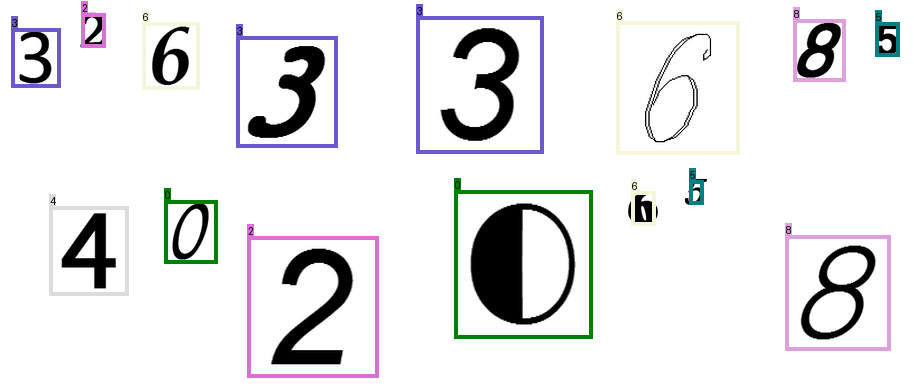



 337 >  cartel_328722085334986.xml


 338 >  cartel_329120624409322.xml


 339 >  cartel_329908268652581.xml


 340 >  cartel_331562515464447.xml


 341 >  cartel_334821647169302.xml


 342 >  cartel_335095969459005.xml


 343 >  cartel_335297995296494.xml


 344 >  cartel_335995277546838.xml


 345 >  cartel_339106997429701.xml


 346 >  cartel_340748830662939.xml


 347 >  cartel_340967080072826.xml




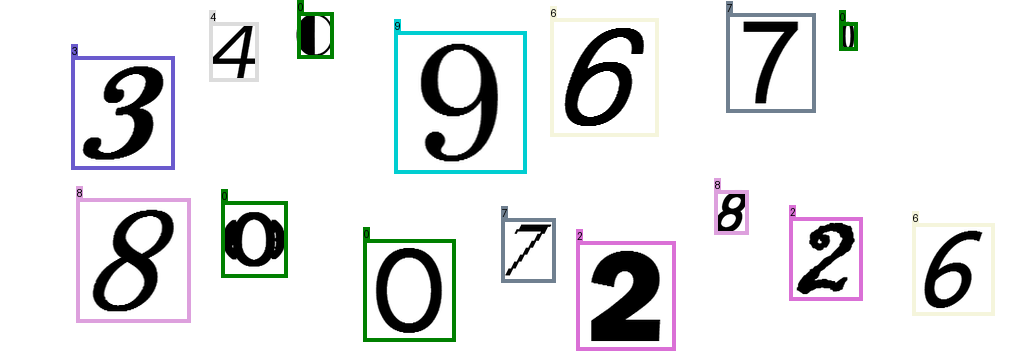



 348 >  cartel_341348956579964.xml


 349 >  cartel_342294609528180.xml


 350 >  cartel_343484111059286.xml


 351 >  cartel_343584388835642.xml


 352 >  cartel_344709814751448.xml


 353 >  cartel_349796272074426.xml


 354 >  cartel_351443877003368.xml


 355 >  cartel_351790892912865.xml


 356 >  cartel_353847032710400.xml


 357 >  cartel_354702338448450.xml


 358 >  cartel_355350726226139.xml


 359 >  cartel_355418523004686.xml


 360 >  cartel_357179173128348.xml


 361 >  cartel_358088774198184.xml


 362 >  cartel_358206581556612.xml


 363 >  cartel_359193587384035.xml




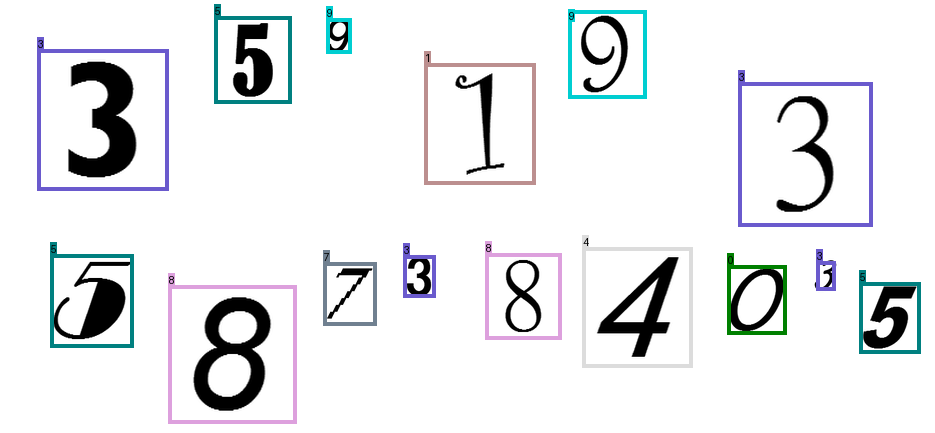



 364 >  cartel_365273129823793.xml


 365 >  cartel_366054395729346.xml


 366 >  cartel_367132062163002.xml


 367 >  cartel_367191435583486.xml


 368 >  cartel_367847819597699.xml




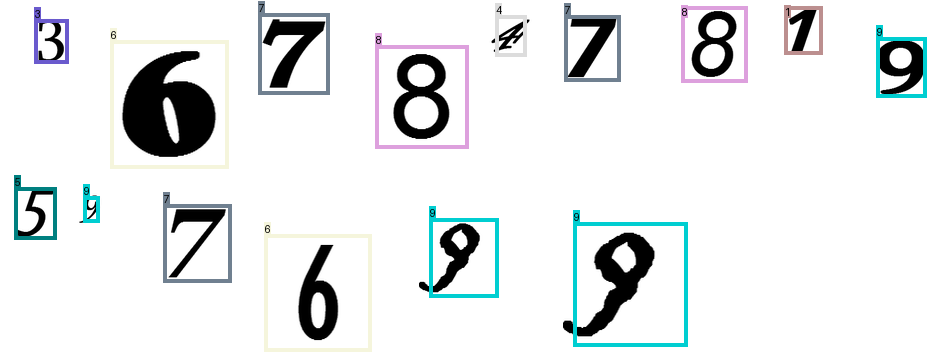



 369 >  cartel_368199227269991.xml


 370 >  cartel_368970479527384.xml


 371 >  cartel_369072629599043.xml


 372 >  cartel_371772097991481.xml


 373 >  cartel_373407267637846.xml


 374 >  cartel_373964039509781.xml


 375 >  cartel_377048157404874.xml


 376 >  cartel_378201072197520.xml


 377 >  cartel_378796112607321.xml


 378 >  cartel_379368566674856.xml


 379 >  cartel_379580936660364.xml


 380 >  cartel_379686751344376.xml


 381 >  cartel_382611750072972.xml


 382 >  cartel_382793321379528.xml


 383 >  cartel_383794288202307.xml


 384 >  cartel_384567807579263.xml


 385 >  cartel_386307854048791.xml


 386 >  cartel_387539432469151.xml


 387 >  cartel_388274001313794.xml




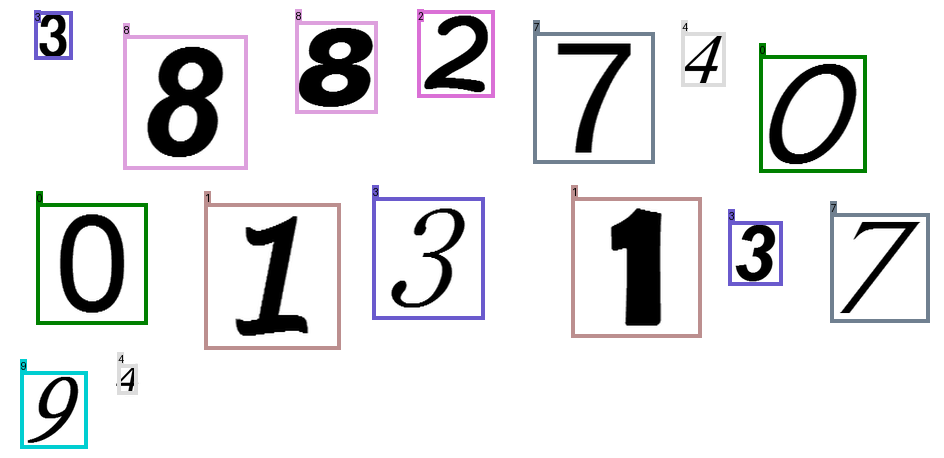



 388 >  cartel_390918193596735.xml




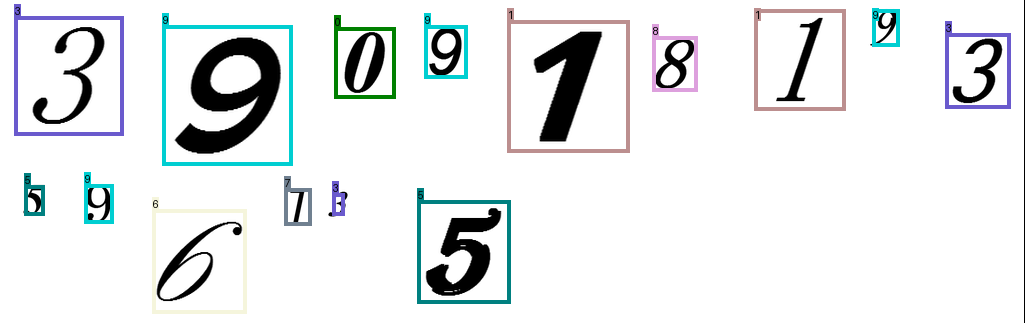



 389 >  cartel_391460067125414.xml


 390 >  cartel_391711320199463.xml


 391 >  cartel_392840194693322.xml


 392 >  cartel_395457937754844.xml


 393 >  cartel_396080040742209.xml


 394 >  cartel_396981769960780.xml


 395 >  cartel_399175497395091.xml


 396 >  cartel_399703693753917.xml


 397 >  cartel_400387849078741.xml


 398 >  cartel_403818212505546.xml


 399 >  cartel_406741117138424.xml


 400 >  cartel_407042846096066.xml


 401 >  cartel_407193659724014.xml


 402 >  cartel_407244201764419.xml


 403 >  cartel_407504647611159.xml


 404 >  cartel_408489822938907.xml


 405 >  cartel_408894524896855.xml


 406 >  cartel_411029009736315.xml


 407 >  cartel_411194355258163.xml


 408 >  cartel_411679449591041.xml


 409 >  cartel_412561910967538.xml




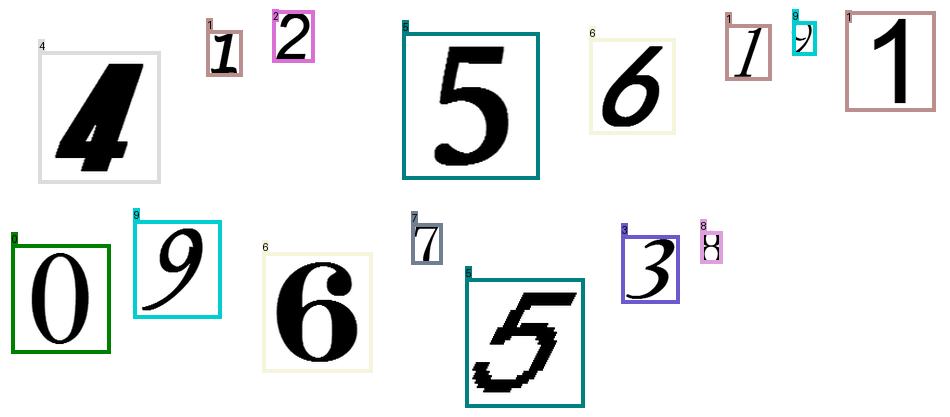



 410 >  cartel_412952792187554.xml


 411 >  cartel_413215459686713.xml


 412 >  cartel_414907293998436.xml


 413 >  cartel_416223087728380.xml


 414 >  cartel_417091946295781.xml


 415 >  cartel_417652711014750.xml


 416 >  cartel_419685881501503.xml


 417 >  cartel_419819804456019.xml


 418 >  cartel_419887660092322.xml


 419 >  cartel_421273340337313.xml


 420 >  cartel_421999891023733.xml


 421 >  cartel_422525023422534.xml


 422 >  cartel_423394602316202.xml


 423 >  cartel_424018804058676.xml


 424 >  cartel_424187498395193.xml


 425 >  cartel_424315990496088.xml


 426 >  cartel_424578301667977.xml


 427 >  cartel_425519532069200.xml


 428 >  cartel_426439261031756.xml


 429 >  cartel_431121670402037.xml


 430 >  cartel_431589662753495.xml


 431 >  cartel_431698924304119.xml


 432 >  cartel_432383644851958.xml


 433 >  cartel_434676046418999.xml


 434 >  cartel_434988452713644.xml


 435 >  cartel_435914085244469.xml


 436 >  cartel_436774398255824.xml



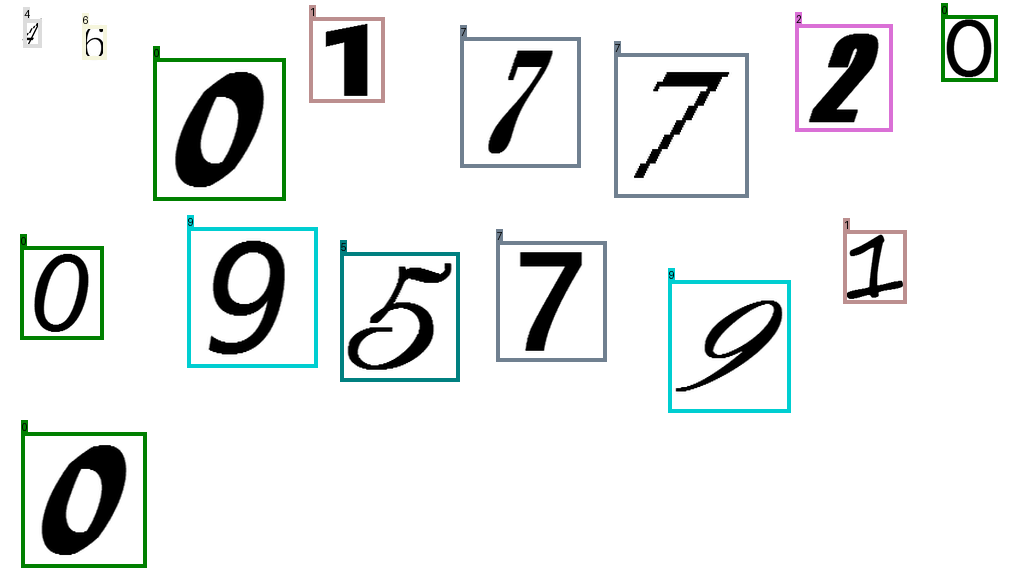



 457 >  cartel_460901077415983.xml


 458 >  cartel_462788227729792.xml


 459 >  cartel_463400087233919.xml


 460 >  cartel_471492928664987.xml


 461 >  cartel_471804119202543.xml


 462 >  cartel_473548216488146.xml


 463 >  cartel_474093483926912.xml


 464 >  cartel_474916054109147.xml


 465 >  cartel_475021028066559.xml




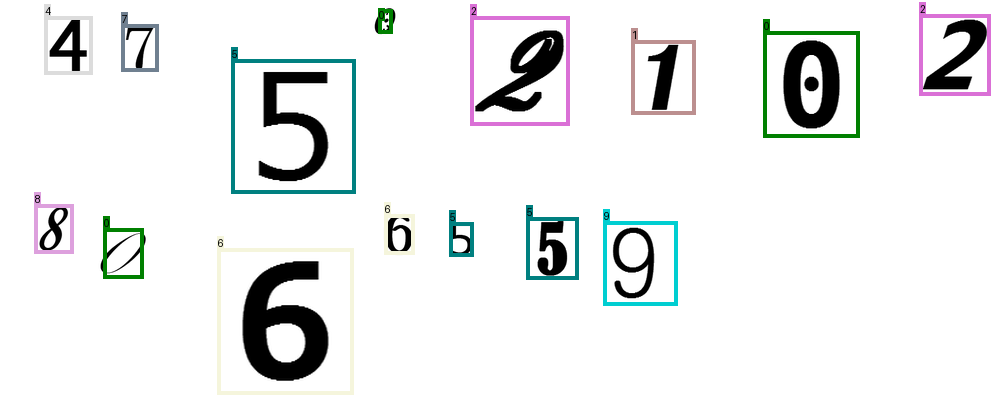



 466 >  cartel_475736975884539.xml


 467 >  cartel_476366811893681.xml


 468 >  cartel_476419630884287.xml


 469 >  cartel_476497047136246.xml


 470 >  cartel_476656175527080.xml


 471 >  cartel_477141617463507.xml


 472 >  cartel_478672757203751.xml


 473 >  cartel_479596966129905.xml


 474 >  cartel_479953005590417.xml


 475 >  cartel_481490284532230.xml


 476 >  cartel_481865826532402.xml


 477 >  cartel_482442013429217.xml




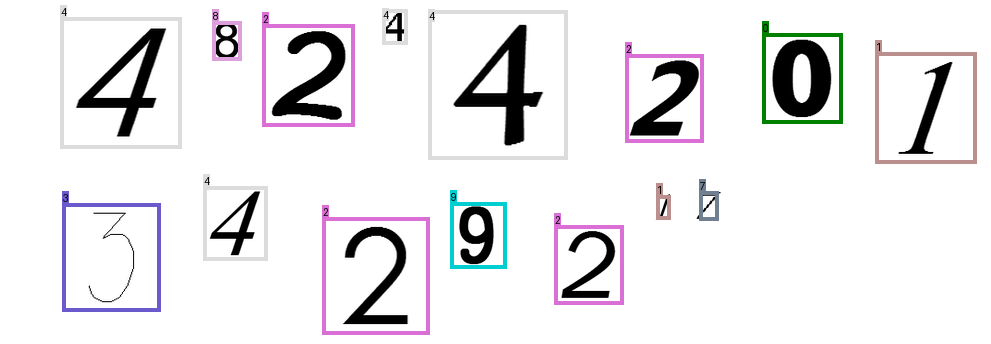



 478 >  cartel_482552638885439.xml


 479 >  cartel_483212732877602.xml


 480 >  cartel_483236052981263.xml


 481 >  cartel_484079069390632.xml


 482 >  cartel_484426763162355.xml


 483 >  cartel_484502106691763.xml


 484 >  cartel_485024727228414.xml


 485 >  cartel_485751123704333.xml


 486 >  cartel_485918206904898.xml


 487 >  cartel_486288725119692.xml


 488 >  cartel_487258164808355.xml


 489 >  cartel_487977938534521.xml


 490 >  cartel_487999526712023.xml


 491 >  cartel_488309277711607.xml


 492 >  cartel_488380544702683.xml


 493 >  cartel_488704496901482.xml


 494 >  cartel_488946575804984.xml


 495 >  cartel_491012429802900.xml




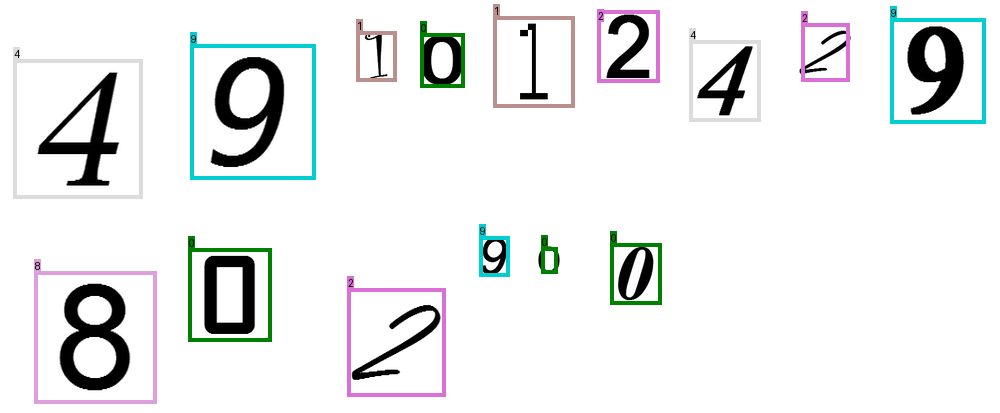



 496 >  cartel_491152028980171.xml


 497 >  cartel_491796768051857.xml


 498 >  cartel_492890430452906.xml


 499 >  cartel_493345236676636.xml


 500 >  cartel_494992540146830.xml


 501 >  cartel_495028588088905.xml


 502 >  cartel_495818732155240.xml


 503 >  cartel_496400532431329.xml


 504 >  cartel_497920038294777.xml


 505 >  cartel_498064779324605.xml


 506 >  cartel_498498698765865.xml


 507 >  cartel_498758149191893.xml


 508 >  cartel_499764597120351.xml


 509 >  cartel_501461214047293.xml


 510 >  cartel_501931189952271.xml


 511 >  cartel_503639060872616.xml


 512 >  cartel_504157240810705.xml


 513 >  cartel_504964069969298.xml


 514 >  cartel_505057243864207.xml


 515 >  cartel_505356172299519.xml




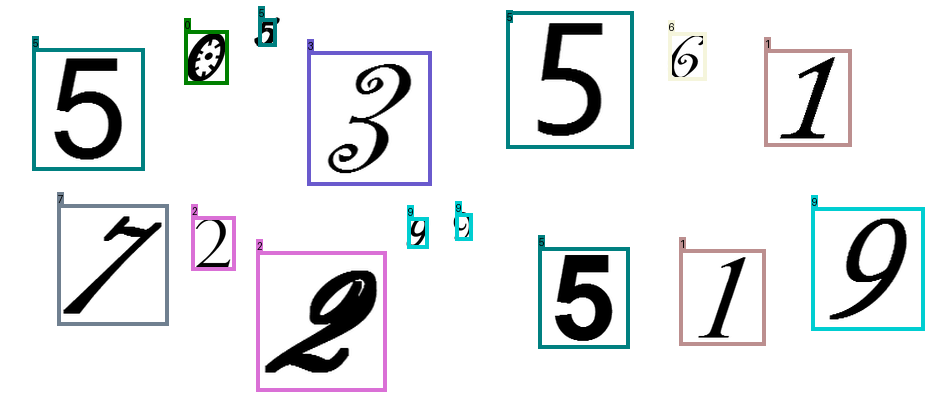



 516 >  cartel_505521466062454.xml


 517 >  cartel_507172623072086.xml


 518 >  cartel_509397807401189.xml


 519 >  cartel_511405639100832.xml


 520 >  cartel_515510862038079.xml


 521 >  cartel_516409832503536.xml


 522 >  cartel_517145764743299.xml


 523 >  cartel_518279411515168.xml


 524 >  cartel_519810807065357.xml


 525 >  cartel_520318420714491.xml


 526 >  cartel_521015551281080.xml


 527 >  cartel_521369939600450.xml


 528 >  cartel_521558980997634.xml


 529 >  cartel_521749370863727.xml


 530 >  cartel_521968026647325.xml


 531 >  cartel_522377161935289.xml


 532 >  cartel_522498388130509.xml


 533 >  cartel_522670250699714.xml


 534 >  cartel_522686335327893.xml


 535 >  cartel_523241668183521.xml


 536 >  cartel_524130149763556.xml


 537 >  cartel_524278452062787.xml


 538 >  cartel_525920157182724.xml


 539 >  cartel_525934951354901.xml


 540 >  cartel_526146251265981.xml


 541 >  cartel_526411915560165.xml


 542 >  cartel_527089729719938.xml



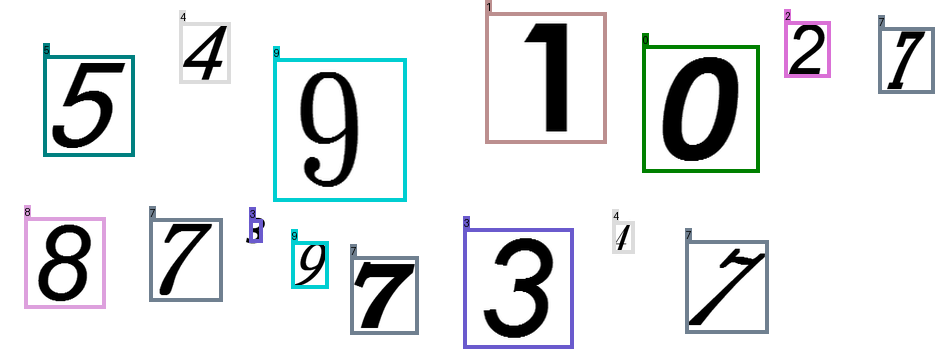



 557 >  cartel_549180948612638.xml


 558 >  cartel_549194865889698.xml


 559 >  cartel_549349643280714.xml


 560 >  cartel_550201701822152.xml


 561 >  cartel_550893063581142.xml


 562 >  cartel_551338047832763.xml




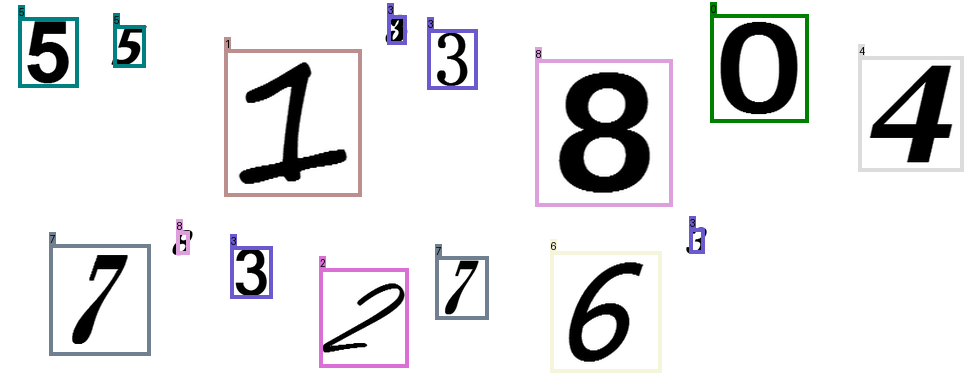



 563 >  cartel_551944237669631.xml


 564 >  cartel_553449938184649.xml


 565 >  cartel_554031641892939.xml


 566 >  cartel_554388184376753.xml


 567 >  cartel_555036798765046.xml


 568 >  cartel_556009124791767.xml


 569 >  cartel_556160690045027.xml


 570 >  cartel_556792307568686.xml


 571 >  cartel_557448561571179.xml


 572 >  cartel_557451891468486.xml


 573 >  cartel_558021141406716.xml


 574 >  cartel_560839319361925.xml


 575 >  cartel_561007006599096.xml


 576 >  cartel_562670007597818.xml


 577 >  cartel_563866383893112.xml


 578 >  cartel_565192105712822.xml


 579 >  cartel_565808272546394.xml


 580 >  cartel_567076098294358.xml


 581 >  cartel_567129661554667.xml


 582 >  cartel_567865816089074.xml


 583 >  cartel_567994419306451.xml


 584 >  cartel_570614267241102.xml


 585 >  cartel_572089174755172.xml




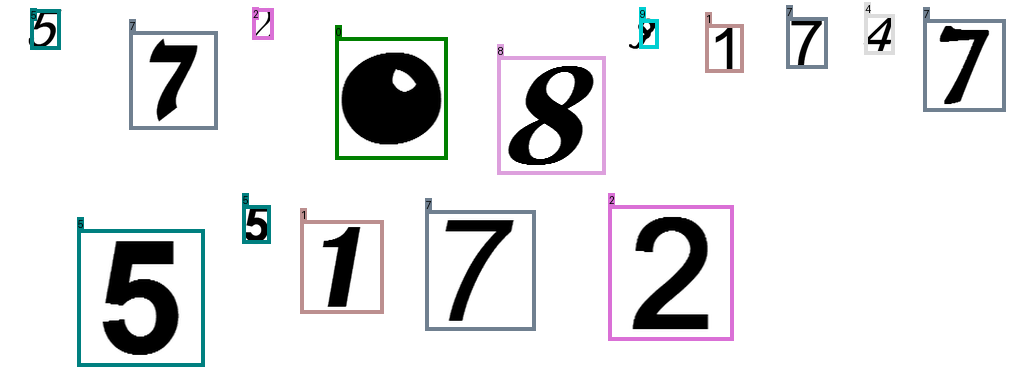



 586 >  cartel_572573260155230.xml


 587 >  cartel_572858590238802.xml


 588 >  cartel_574237607224885.xml


 589 >  cartel_574743241442343.xml


 590 >  cartel_576808230580461.xml


 591 >  cartel_576841502522930.xml


 592 >  cartel_577380957872157.xml


 593 >  cartel_578536787917079.xml


 594 >  cartel_578650667875704.xml


 595 >  cartel_583540556930125.xml


 596 >  cartel_585912204281960.xml


 597 >  cartel_587317288399390.xml


 598 >  cartel_588658913369164.xml


 599 >  cartel_588813183784115.xml




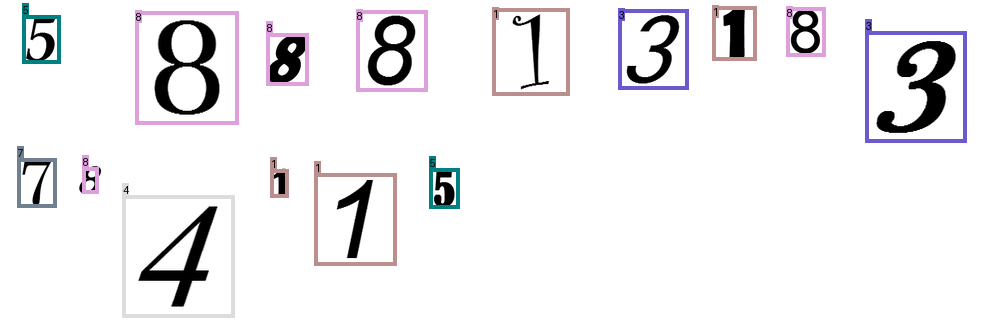



 600 >  cartel_589674953970800.xml


 601 >  cartel_593907817598048.xml


 602 >  cartel_594029526546797.xml


 603 >  cartel_594593317181312.xml


 604 >  cartel_595099356145895.xml


 605 >  cartel_595550968864772.xml


 606 >  cartel_596321132109345.xml


 607 >  cartel_598406725307692.xml


 608 >  cartel_598609613642178.xml


 609 >  cartel_598678562638402.xml


 610 >  cartel_599263734054506.xml


 611 >  cartel_599999635688701.xml


 612 >  cartel_600738988531184.xml


 613 >  cartel_603803403058988.xml


 614 >  cartel_604015688212327.xml


 615 >  cartel_604389168815814.xml


 616 >  cartel_605026843248282.xml


 617 >  cartel_606565723506481.xml


 618 >  cartel_606804027282103.xml


 619 >  cartel_607254318103568.xml


 620 >  cartel_607931837189447.xml


 621 >  cartel_607971440463927.xml


 622 >  cartel_612463700628112.xml


 623 >  cartel_615132945018480.xml


 624 >  cartel_615319855190149.xml


 625 >  cartel_616136912473872.xml


 626 >  cartel_616198285016951.xml



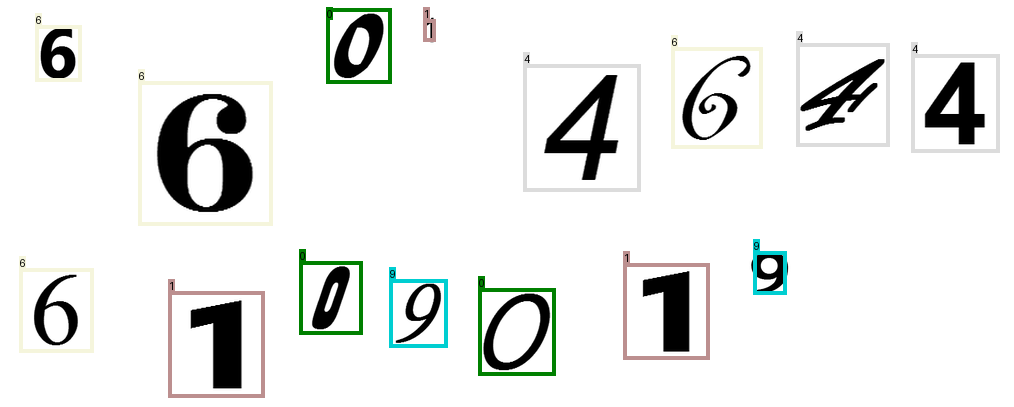



 667 >  cartel_661056950303924.xml


 668 >  cartel_662807464046869.xml


 669 >  cartel_665686057094096.xml


 670 >  cartel_666168283938454.xml


 671 >  cartel_666181877213497.xml


 672 >  cartel_666298145123381.xml


 673 >  cartel_668790133819619.xml


 674 >  cartel_669244368512326.xml


 675 >  cartel_671581984124583.xml


 676 >  cartel_672805627819579.xml


 677 >  cartel_673297088695647.xml


 678 >  cartel_674796871792108.xml


 679 >  cartel_675211241943054.xml


 680 >  cartel_675792205626349.xml


 681 >  cartel_676730583914875.xml




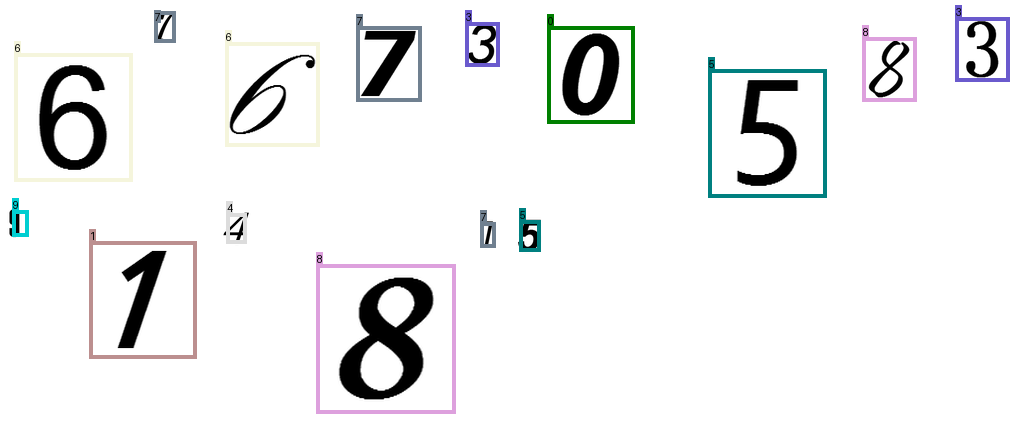



 682 >  cartel_677987235854347.xml


 683 >  cartel_678150499537617.xml


 684 >  cartel_678506476535861.xml


 685 >  cartel_679284387622019.xml


 686 >  cartel_679442195111622.xml


 687 >  cartel_680968030442883.xml


 688 >  cartel_682988368767462.xml


 689 >  cartel_683692449172243.xml


 690 >  cartel_683928631483040.xml


 691 >  cartel_684707628917718.xml


 692 >  cartel_684720158980397.xml


 693 >  cartel_684823375247605.xml


 694 >  cartel_685033680433885.xml


 695 >  cartel_685049487327397.xml


 696 >  cartel_685066141740136.xml


 697 >  cartel_685751077449846.xml


 698 >  cartel_686854100612546.xml


 699 >  cartel_688033925520849.xml


 700 >  cartel_691559176734359.xml


 701 >  cartel_693269170713488.xml


 702 >  cartel_694465238937658.xml


 703 >  cartel_695029791425238.xml


 704 >  cartel_696072827734076.xml


 705 >  cartel_696339701994954.xml


 706 >  cartel_698290721434027.xml


 707 >  cartel_698466015584696.xml


 708 >  cartel_701403962900729.xml



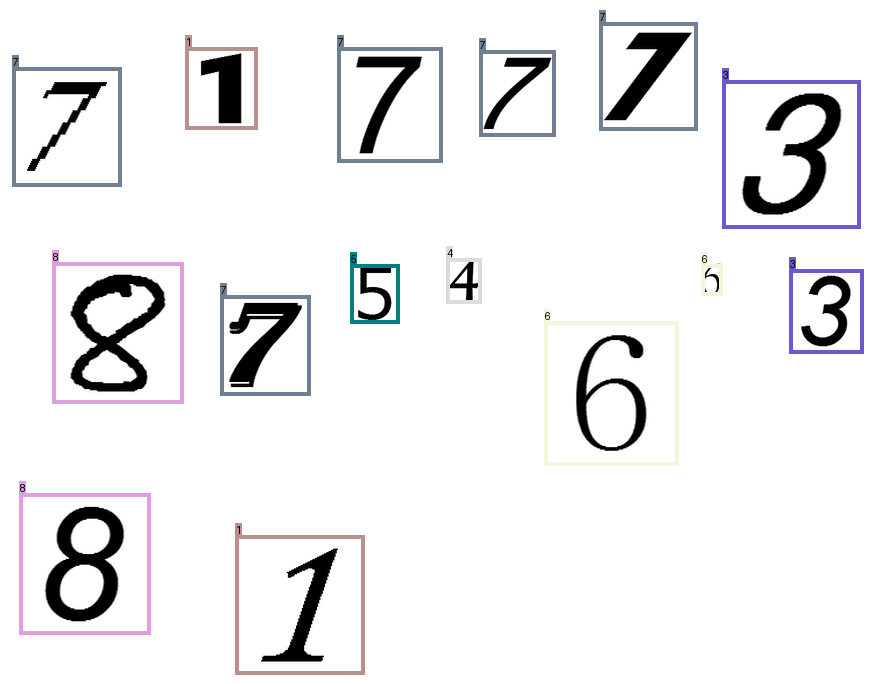



 723 >  cartel_719283169390376.xml


 724 >  cartel_720416311909930.xml


 725 >  cartel_721393111561540.xml




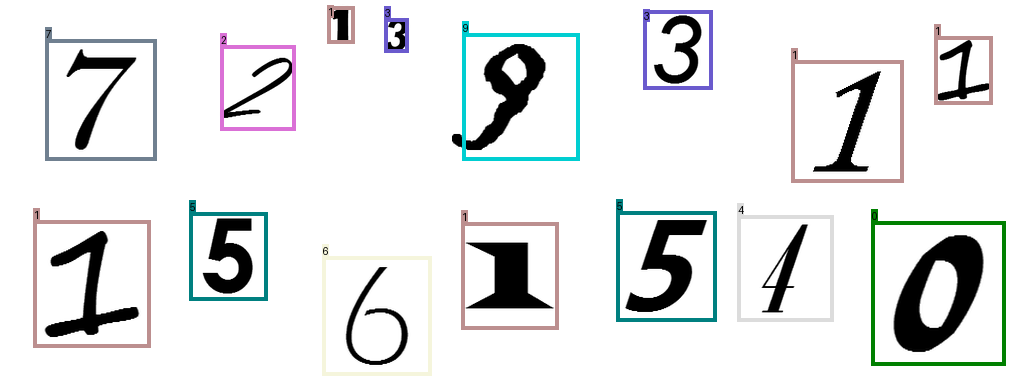



 726 >  cartel_722141238522305.xml


 727 >  cartel_723681111534437.xml


 728 >  cartel_725401889609182.xml


 729 >  cartel_726763646821131.xml


 730 >  cartel_727711051928534.xml


 731 >  cartel_728723513820005.xml


 732 >  cartel_729100101733322.xml


 733 >  cartel_731277179328170.xml


 734 >  cartel_734225198122156.xml


 735 >  cartel_735247015029601.xml




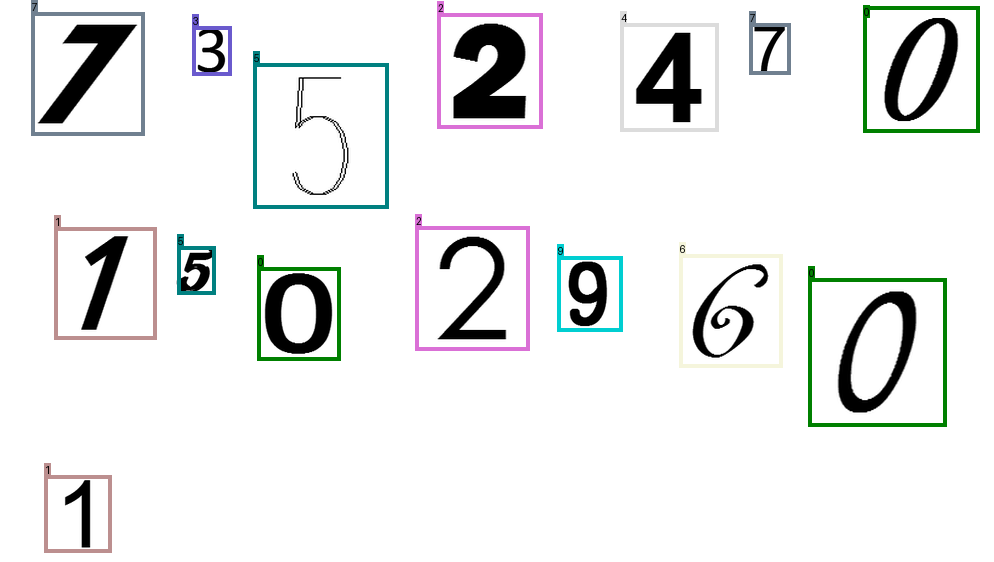



 736 >  cartel_737192015531742.xml


 737 >  cartel_737634338964928.xml


 738 >  cartel_738659192271931.xml


 739 >  cartel_740160616784900.xml




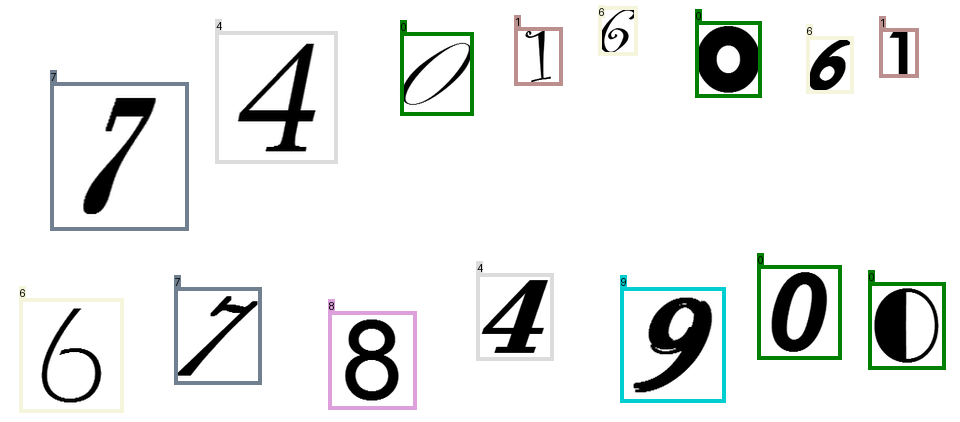



 740 >  cartel_741579871499813.xml


 741 >  cartel_741957952367136.xml


 742 >  cartel_743666800028732.xml


 743 >  cartel_743772379707877.xml


 744 >  cartel_743852943303725.xml


 745 >  cartel_743930595084554.xml


 746 >  cartel_745025873738172.xml


 747 >  cartel_746500296215569.xml


 748 >  cartel_748609966167527.xml


 749 >  cartel_750998277921455.xml


 750 >  cartel_751322169337858.xml


 751 >  cartel_753673350182637.xml


 752 >  cartel_754172028077049.xml


 753 >  cartel_755363513654207.xml


 754 >  cartel_755416649888758.xml


 755 >  cartel_755934360225036.xml


 756 >  cartel_756541198834198.xml


 757 >  cartel_758592563307076.xml


 758 >  cartel_760817737062064.xml


 759 >  cartel_761194081173377.xml


 760 >  cartel_761453013643177.xml


 761 >  cartel_761574279589163.xml


 762 >  cartel_761954043688308.xml


 763 >  cartel_762390190447519.xml


 764 >  cartel_762602600015041.xml


 765 >  cartel_764120579747135.xml


 766 >  cartel_766081546427643.xml



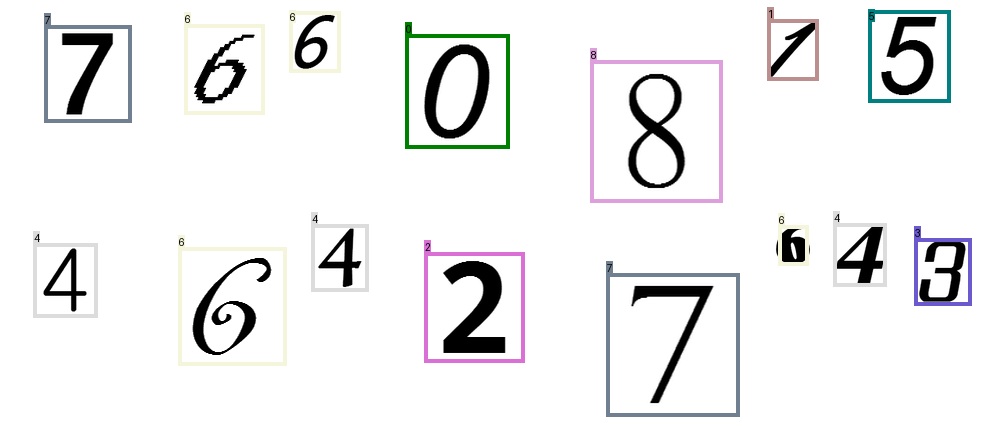



 767 >  cartel_768990195982664.xml


 768 >  cartel_770237212384859.xml


 769 >  cartel_770470198787516.xml


 770 >  cartel_771570312574887.xml


 771 >  cartel_775424509130470.xml


 772 >  cartel_778163411393431.xml


 773 >  cartel_779878910886007.xml


 774 >  cartel_780856375070546.xml


 775 >  cartel_780919537585156.xml


 776 >  cartel_787019461606481.xml


 777 >  cartel_788675891305054.xml


 778 >  cartel_788701881517410.xml


 779 >  cartel_789048882645371.xml


 780 >  cartel_789219646671321.xml


 781 >  cartel_792537124631943.xml


 782 >  cartel_792971662752676.xml


 783 >  cartel_793744535973296.xml




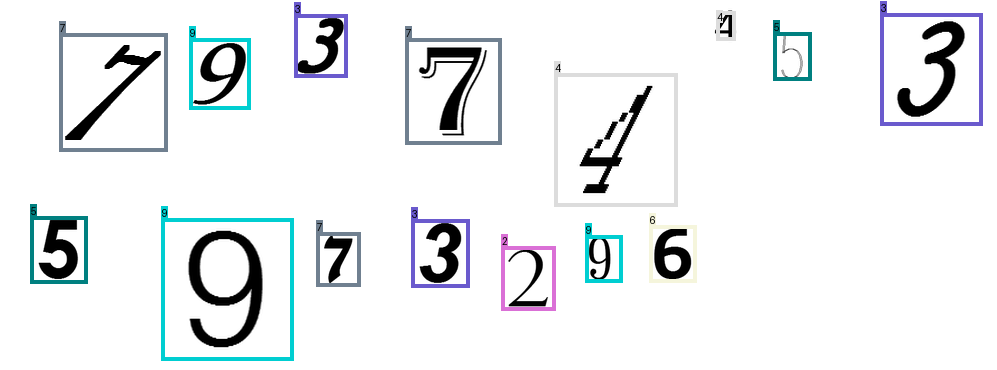



 784 >  cartel_794095894857796.xml


 785 >  cartel_794792830386286.xml


 786 >  cartel_795922906795783.xml


 787 >  cartel_797694791845736.xml


 788 >  cartel_797755813893044.xml


 789 >  cartel_798194529465357.xml


 790 >  cartel_798639498228005.xml


 791 >  cartel_798792547840599.xml


 792 >  cartel_802317767394790.xml




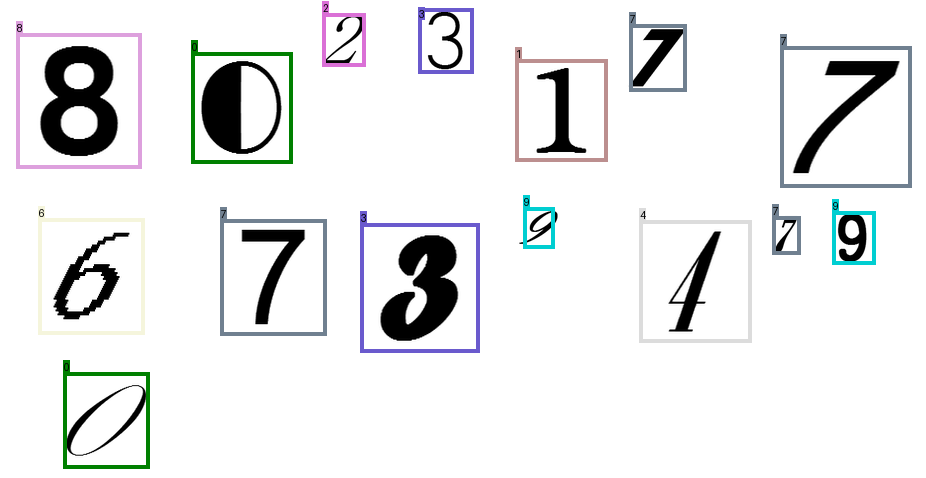



 793 >  cartel_802898443650136.xml


 794 >  cartel_803339561315815.xml


 795 >  cartel_803453910398842.xml


 796 >  cartel_806997317881362.xml


 797 >  cartel_808113761744259.xml


 798 >  cartel_808321746017823.xml


 799 >  cartel_808577613611060.xml


 800 >  cartel_808744945877168.xml


 801 >  cartel_809929541677702.xml


 802 >  cartel_810711803159157.xml


 803 >  cartel_810886926395699.xml


 804 >  cartel_811839355313016.xml


 805 >  cartel_812683183097334.xml


 806 >  cartel_813091862535387.xml


 807 >  cartel_813371229351691.xml




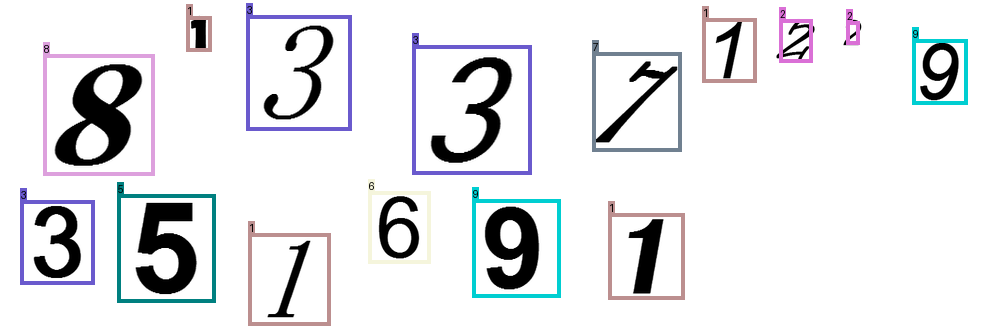



 808 >  cartel_816612072795044.xml


 809 >  cartel_816663654834194.xml




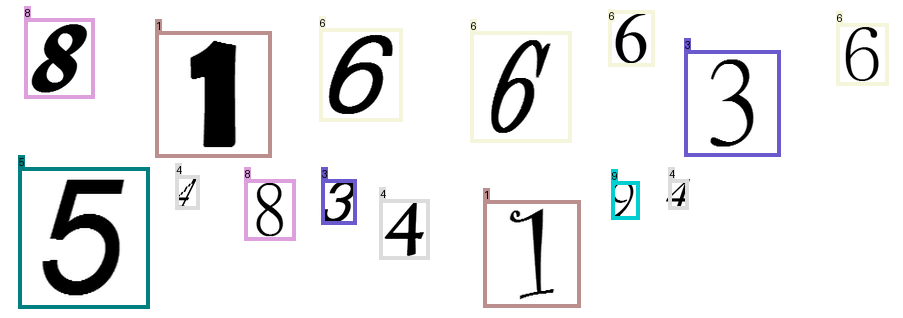



 810 >  cartel_817177660927772.xml


 811 >  cartel_817863017876373.xml


 812 >  cartel_821808607061530.xml


 813 >  cartel_822214544589867.xml


 814 >  cartel_822628152610500.xml


 815 >  cartel_824246108455505.xml


 816 >  cartel_825907534643900.xml


 817 >  cartel_826943655726872.xml


 818 >  cartel_827206694210434.xml


 819 >  cartel_827598304247999.xml


 820 >  cartel_828431141939469.xml


 821 >  cartel_828676900729452.xml


 822 >  cartel_829959714275701.xml


 823 >  cartel_830309764047795.xml


 824 >  cartel_832021051573911.xml


 825 >  cartel_832576570019180.xml


 826 >  cartel_832963998773904.xml


 827 >  cartel_833328351744388.xml


 828 >  cartel_833358931642063.xml


 829 >  cartel_835286838084454.xml


 830 >  cartel_835472732244732.xml




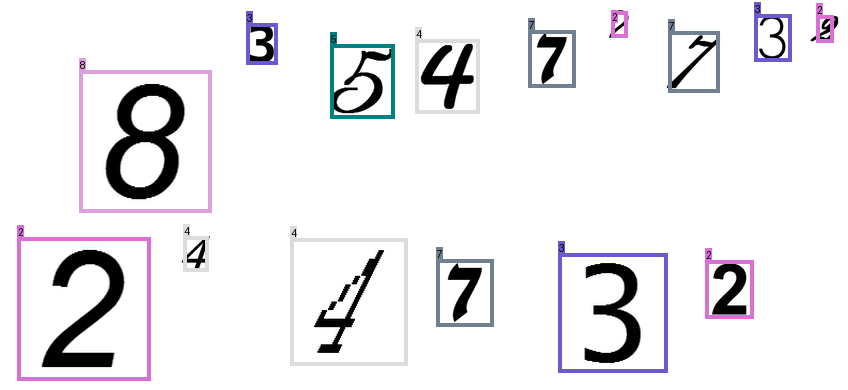



 831 >  cartel_836243185153860.xml


 832 >  cartel_837003238416516.xml




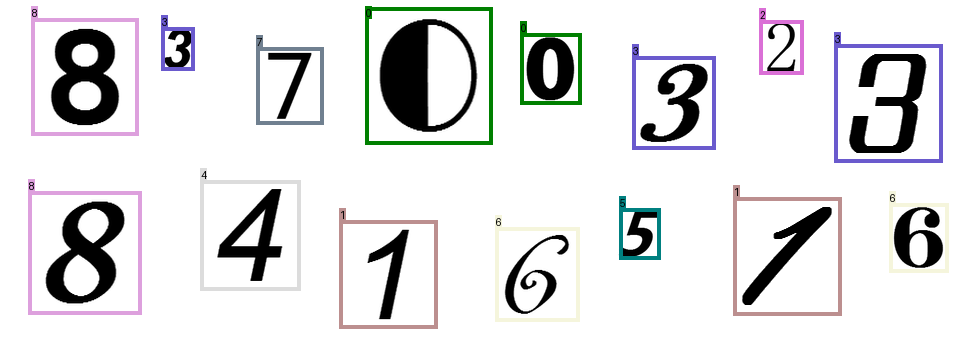



 833 >  cartel_837442496632828.xml


 834 >  cartel_837973059308730.xml


 835 >  cartel_840228838095568.xml


 836 >  cartel_841737637052283.xml


 837 >  cartel_843198835953625.xml


 838 >  cartel_845078872162952.xml


 839 >  cartel_847309419991007.xml


 840 >  cartel_847352761432492.xml




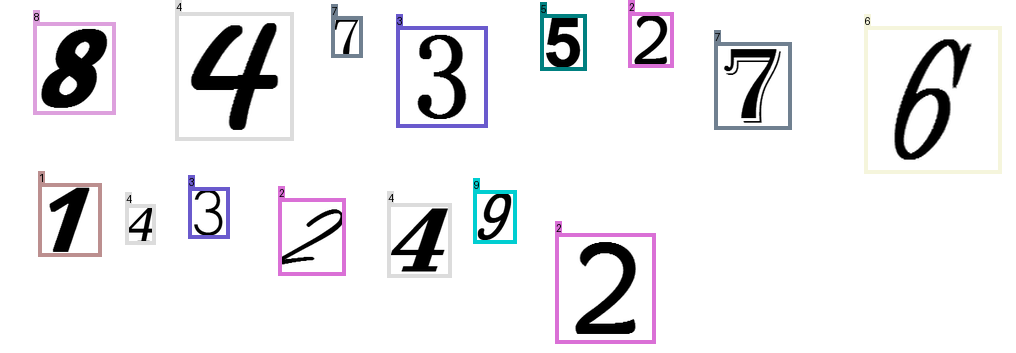



 841 >  cartel_847891421864210.xml


 842 >  cartel_848000485257018.xml


 843 >  cartel_849899635165918.xml


 844 >  cartel_851015016968588.xml


 845 >  cartel_852584470436429.xml


 846 >  cartel_853531515530087.xml


 847 >  cartel_854483950933099.xml


 848 >  cartel_855084833788226.xml


 849 >  cartel_856638598936366.xml


 850 >  cartel_858385600954802.xml


 851 >  cartel_858770149865599.xml


 852 >  cartel_859470850588044.xml


 853 >  cartel_859614430258501.xml


 854 >  cartel_862372358667020.xml


 855 >  cartel_862519243889157.xml


 856 >  cartel_862573286199724.xml


 857 >  cartel_864477219951009.xml


 858 >  cartel_864954172714346.xml


 859 >  cartel_865822359838998.xml




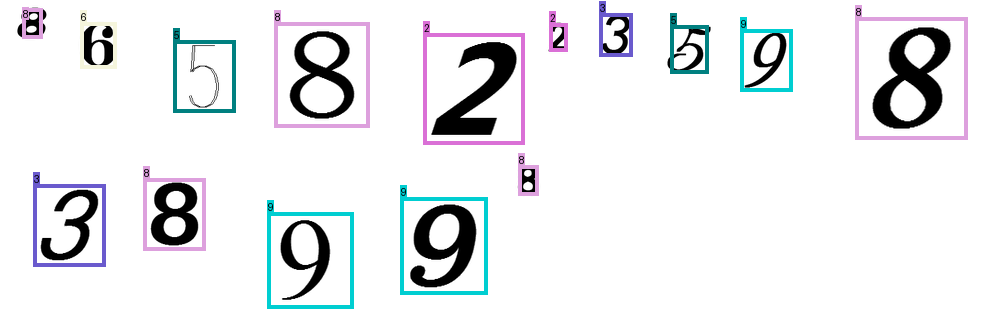



 860 >  cartel_867651704713507.xml


 861 >  cartel_867798951422632.xml


 862 >  cartel_869172173617901.xml


 863 >  cartel_869286173931217.xml


 864 >  cartel_869444648062619.xml


 865 >  cartel_871585597924608.xml


 866 >  cartel_872858377286425.xml




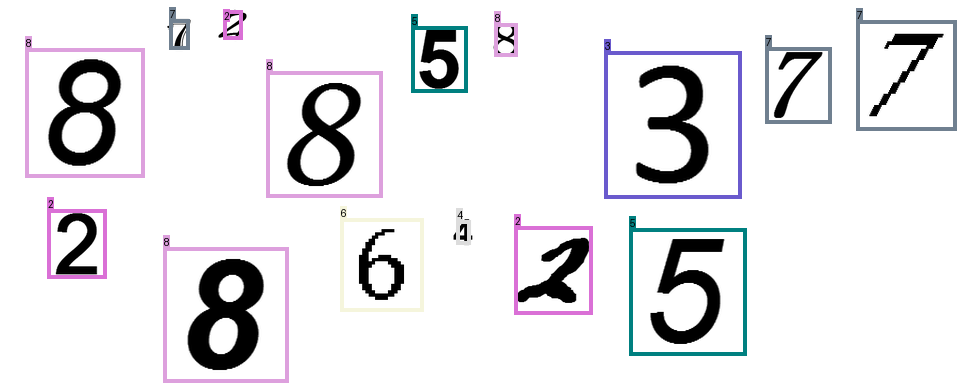



 867 >  cartel_873317568517667.xml


 868 >  cartel_873460796673760.xml


 869 >  cartel_873685792839196.xml


 870 >  cartel_875861814080788.xml


 871 >  cartel_877915308770417.xml


 872 >  cartel_878723929131334.xml


 873 >  cartel_879176987825695.xml


 874 >  cartel_880219465188195.xml


 875 >  cartel_880847634496458.xml




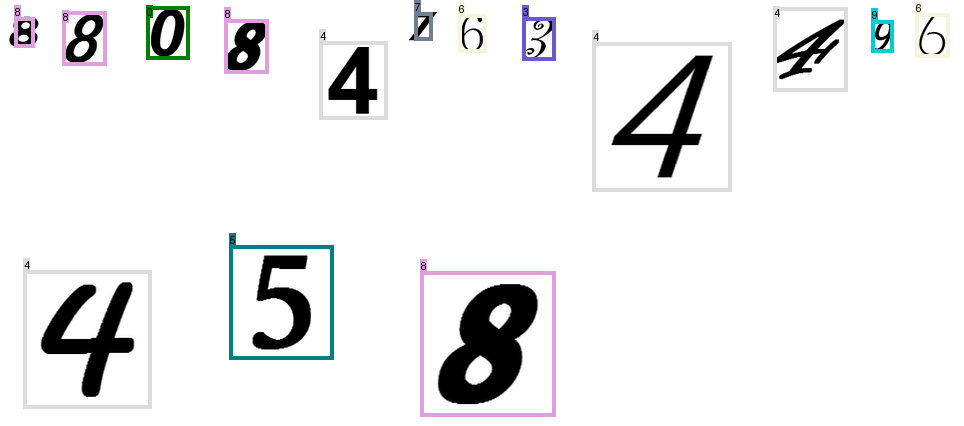



 876 >  cartel_882269096067750.xml


 877 >  cartel_882626974157995.xml


 878 >  cartel_882948892779623.xml


 879 >  cartel_883621896061586.xml


 880 >  cartel_883716090059663.xml


 881 >  cartel_888040712776166.xml


 882 >  cartel_888508739486478.xml


 883 >  cartel_891187748967472.xml


 884 >  cartel_893505642679233.xml


 885 >  cartel_893944324459559.xml


 886 >  cartel_895421987865572.xml


 887 >  cartel_895956191603935.xml


 888 >  cartel_896177854758452.xml


 889 >  cartel_896652431809072.xml


 890 >  cartel_898188075887915.xml


 891 >  cartel_899871659451680.xml


 892 >  cartel_899876785511294.xml


 893 >  cartel_900617184554380.xml


 894 >  cartel_900829825923806.xml


 895 >  cartel_901216737431386.xml


 896 >  cartel_902467411263199.xml


 897 >  cartel_903050274357043.xml


 898 >  cartel_903321426201989.xml


 899 >  cartel_905026538643775.xml


 900 >  cartel_906699083894984.xml


 901 >  cartel_908338906217024.xml


 902 >  cartel_909663485761205.xml



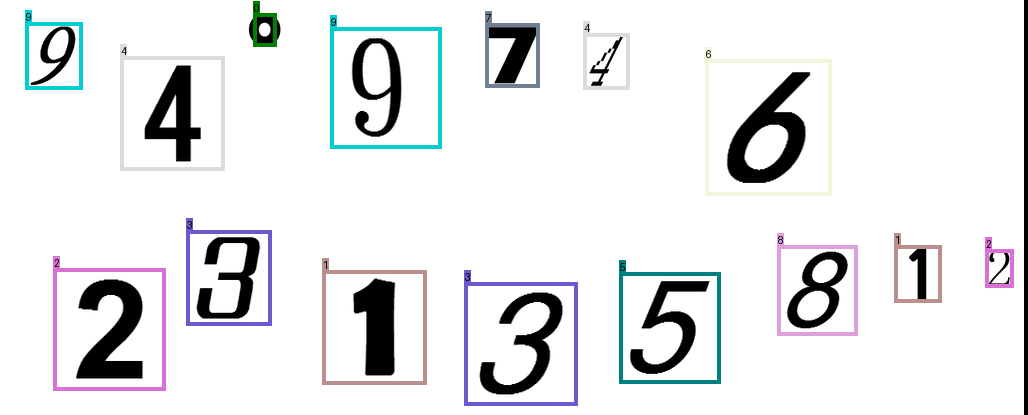



 938 >  cartel_941225159963437.xml




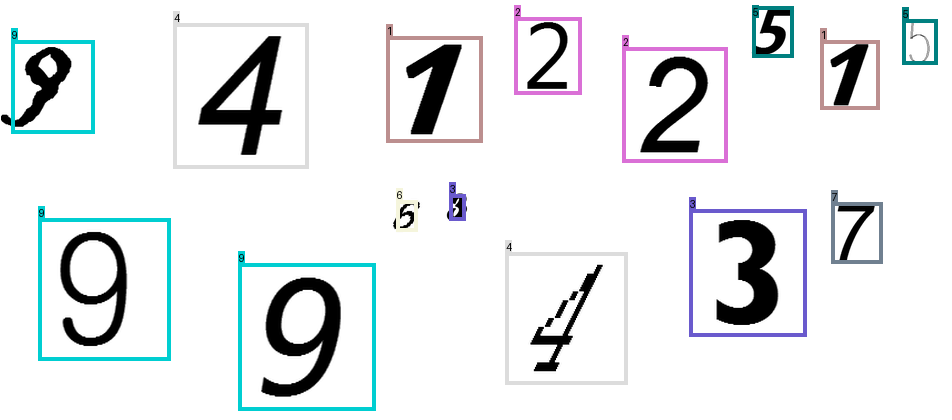



 939 >  cartel_942263518844955.xml


 940 >  cartel_943125766034509.xml


 941 >  cartel_943545481287339.xml


 942 >  cartel_948963255404220.xml


 943 >  cartel_950176853895760.xml


 944 >  cartel_950704252602113.xml


 945 >  cartel_951603850416071.xml


 946 >  cartel_951843883298854.xml


 947 >  cartel_952465216049273.xml


 948 >  cartel_953853928203103.xml


 949 >  cartel_954139938823560.xml


 950 >  cartel_955121826560222.xml


 951 >  cartel_956387242807635.xml


 952 >  cartel_956968857928957.xml


 953 >  cartel_959995190575080.xml


 954 >  cartel_960321372225758.xml


 955 >  cartel_961331556057132.xml


 956 >  cartel_961480677273188.xml


 957 >  cartel_964502724122963.xml


 958 >  cartel_964779368654188.xml


 959 >  cartel_964979926778188.xml


 960 >  cartel_966336269612246.xml


 961 >  cartel_967812632876974.xml


 962 >  cartel_967876129293049.xml


 963 >  cartel_968389163902411.xml


 964 >  cartel_968809747300352.xml


 965 >  cartel_968890396887176.xml



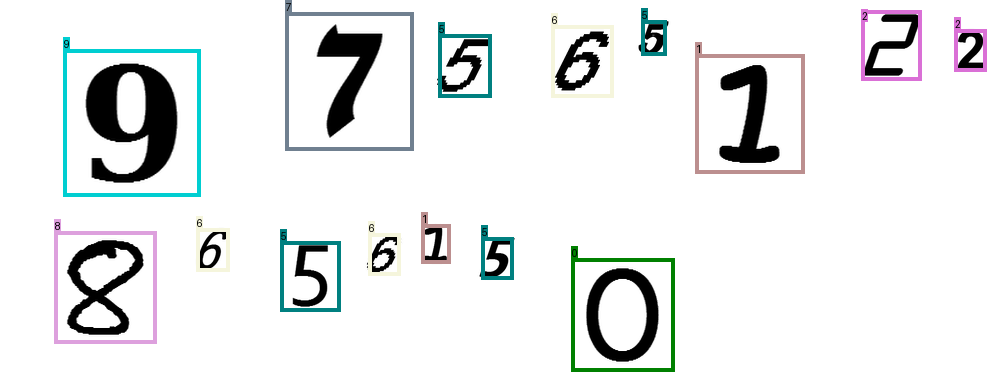



 973 >  cartel_975938537515748.xml


 974 >  cartel_976572440172545.xml


 975 >  cartel_976769178564883.xml


 976 >  cartel_977351411350205.xml


 977 >  cartel_977537057982191.xml


 978 >  cartel_977994878867509.xml


 979 >  cartel_979523278854457.xml


 980 >  cartel_983623339490147.xml




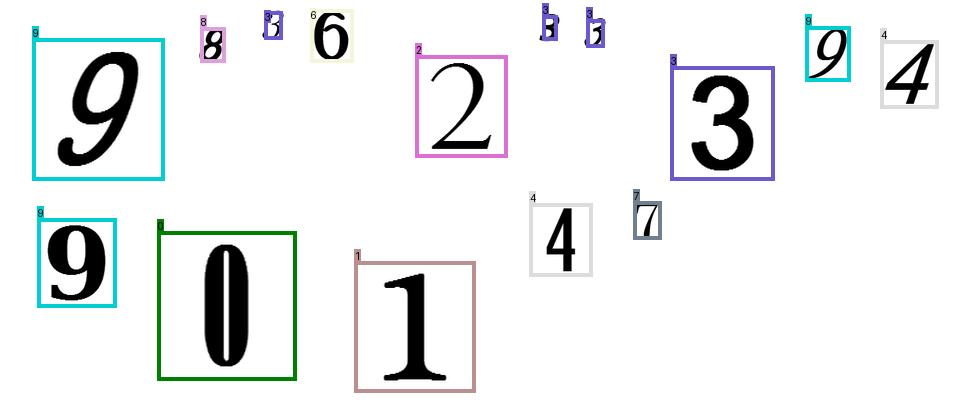



 981 >  cartel_983909907577518.xml


 982 >  cartel_984097319653653.xml


 983 >  cartel_984420322370146.xml


 984 >  cartel_984771575778997.xml


 985 >  cartel_985094736706122.xml


 986 >  cartel_985902340099030.xml


 987 >  cartel_986099006548944.xml


 988 >  cartel_988409838998277.xml


 989 >  cartel_989540969664342.xml


 990 >  cartel_990418387334101.xml


 991 >  cartel_991105870352006.xml


 992 >  cartel_992782366233635.xml


 993 >  cartel_992910206102203.xml


 994 >  cartel_993183288256358.xml


 995 >  cartel_993823377033732.xml


 996 >  cartel_994170942478729.xml


 997 >  cartel_994717697816264.xml


 998 >  cartel_995526589383099.xml


 999 >  cartel_997533355240781.xml


 1000 >  cartel_999604669230079.xml


== Cantidad de XMLs chequeados:  1000

== Cantidad de Errores Totales encontrados:  0

== XMLs con errores:  []


In [17]:
#@title Probar XMLs

# vuelve a ordenar la lista para mostrar bien
all_xml_array.sort()

# arma hash para contar tipo objetos
diccTipoObjCant = {}

# función para cálculo de Intersection over Union (IoU)
def calc_IoU( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = pred_bbox

    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        #raise AssertionError("Ground Truth Bounding Box is not correct")
        return -1
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        #raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        return -1

    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox

        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox

        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox

        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox

        return 0.0

    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)

    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])

    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)

    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)

    return intersection_area/union_area


def draw_text_on_img(draw, display_str_list, box, color):
  (left, top, right, bottom) = box
  try:
    font = ImageFont.truetype('arial.ttf', 24)
  except IOError:
    font = ImageFont.load_default()
  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top  ##- total_display_str_height
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
        fill=color)
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
    text_bottom -= text_height - 2 * margin
    return

def draw_box_on_image(draw, box, color, className=None, line_width=5):
    # dibuja en la imagen
    draw.rectangle(box, outline=color, width=line_width)
    # si tiene que incluir nombre clase
    if className is not None:
      draw_text_on_img(draw, [className], box, color)


# función auxiliar para hacer el chequeo
def checkValoresXML(valMin, valMax, limiteMax, descVal, xml_file, class_name):
  res = 0

  if valMin < 0:
    print("**", xml_file, '-', class_name, 'error: ', descVal, 'min [', valMin, '] < 0')
    res = res + 1

  if valMax < 0:
    print("**", xml_file, '-', class_name, 'error: ', descVal, 'max [', valMax, '] < 0')
    res = res + 1

  if valMin > limiteMax:
    print("**", xml_file, '-', class_name, 'error: ', descVal, 'min [', valMin, '] > límiteMáximo [', limiteMax, '].')
    res = res + 1

  if valMax > limiteMax:
    print("**", xml_file, '-', class_name, 'error: ', descVal, 'max [', valMax, ']  > límiteMáximo [', limiteMax, '].')
    res = res + 1

  if valMin < 0:
    print("**", xml_file, '-', class_name, 'error: ', descVal, 'min [', valMin, '] < 0.')
    res = res + 1

  if valMax < 0:
    print("**", xml_file, '-', class_name, 'error: ', descVal, 'max [', valMax, '] < 0.')
    res = res + 1

  if valMin >= valMax:
      if valMin > valMax:
          print("**", xml_file, '-', class_name, 'error: ', descVal, 'min [', valMin, '] > ', descVal, 'max [', valMax, '].')
          res = res + 1
      else:
          print("**", xml_file, '-', class_name, 'error: ', descVal, 'min [', valMin, '] = ', descVal, 'max[', valMax, '].')
          res = res + 1

  return res

# variable auxiliar
xmlConError = []
cantErroresTotales = 0
cantProcesados = 0
# procesa los XMLs
for xml_file in all_xml_array:
    # variables auxiliares para chequear duplicados
    auxListCheckDupPos = []
    auxListCheckDupClass = []
    cantErrores = 0

    cantProcesados = cantProcesados + 1
    print("\n\n", cantProcesados,"> ", xml_file)
    if not os.path.isfile(data_dir_path + '/' + xml_file):
      print("\tno se encuentra el archivo xml!")
      continue

    # decide si muestra la imagen asociada a este XML
    muestraImagen = ((xml_file in mostrar_xml_array) and mostrarObjetosEnImagen)

    # carga la info del XML original
    et = ET.parse(data_dir_path + '/' + xml_file)
    element = et.getroot()
    element_objs = element.findall('object')
    element_filename = element.find('filename').text
    xmlWidth = element.find('size').find('width').text
    xmlHeight = element.find('size').find('height').text
    ##if not('.png' in element_filename):
    ##    element_filename  = element_filename + '.png'
    img_filename = os.path.join(image_dir_path, element_filename)
    if not os.path.isfile(img_filename):
      print("\tno se encuentra la imagen ", img_filename, "!")
      continue

    if muestraImagen or mostrarImagenOriginal:
      # carga la imagen
      imageCargada = ImPIL.open(img_filename)
      if mostrarImagenOriginal:
          display( imageCargada )

    # imagen auxiliar para mostrar recuadros y obtener tamaño
    img = tf.io.read_file(img_filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = img.numpy()
    image_pil = Image.fromarray(np.uint8(img)).convert("RGB")
    im_width, im_height = image_pil.size
    draw = ImageDraw.Draw(image_pil)

    # controla ancho de la imagen y XML
    if xmlWidth=="" or not xmlWidth.isnumeric():
      print("**", xml_file, "- [size->Width] ", xmlWidth, " inválido!")
      cantErrores = cantErrores + 1
    else:
      if im_width != int(xmlWidth):
        print("**", xml_file, "- [size->Width] ", xmlWidth, " no coincide con ancho de la imagen ", im_width)
        cantErrores = cantErrores + 1
    # controla alto de la imagen y XML
    if xmlHeight=="" or not xmlHeight.isnumeric():
        print("**", xml_file, "- [size->Height] ", xmlHeight, " inválido!")
        cantErrores = cantErrores + 1
    else:
      if im_height != int(xmlHeight):
        print("**", xml_file, "- [size->Height] ", xmlHeight, " no coincide con ancho de la imagen ", im_height)
        cantErrores = cantErrores + 1

    # procesa los elementos en el archivo XML original para generar el nuevo
    for element_obj in element_objs:

        # obtiene la información actual de la imagen
        class_name = element_obj.find('name').text
        if calcularCantTipoObjetos:
          # cuenta tipo de objeto
          if class_name in diccTipoObjCant:
            diccTipoObjCant[class_name] = diccTipoObjCant[class_name] + 1
          else:
            diccTipoObjCant[class_name] = 0

        # obtiene info del box actual
        obj_bbox = element_obj.find('bndbox')
        x1 = int(round(float(obj_bbox.find('xmin').text)))
        y1 = int(round(float(obj_bbox.find('ymin').text)))
        x2 = int(round(float(obj_bbox.find('xmax').text)))
        y2 = int(round(float(obj_bbox.find('ymax').text)))

        # realiza el chequeo del XML
        cantErrores = checkValoresXML(x1, x2, im_width, 'X', xml_file, class_name) + cantErrores
        cantErrores = checkValoresXML(y1, y2, im_height, 'Y', xml_file, class_name) + cantErrores

        # controla que no haya duplicados identicos
        auxVec = (x1, y1, x2, y2)
        if auxVec in auxListCheckDupPos:
            i = auxListCheckDupPos.index( auxVec )
            print("**", xml_file, '- [', class_name, ',', auxVec, '] error registro duplicado con [', auxListCheckDupClass[i], ',', auxListCheckDupPos[i], '].')
            cantErrores = cantErrores + 1
        else:
            # controla que no haya alguno con coordenadas muy parecidas
            if revisarObjetosEncimados:
                i = 0
                while i < len(auxListCheckDupPos):
                  iou = calc_IoU(auxVec, auxListCheckDupPos[i])
                  if iou >= 0.90:
                    print("**", xml_file, '- [', class_name, ',', auxVec, '] error posiciones muy cercanas (IoU ', iou, ') con [', auxListCheckDupClass[i], ',', auxListCheckDupPos[i], '].')
                    cantErrores = cantErrores + 1
                    break
                  i = i + 1
            # lo agrega a la lista
            auxListCheckDupPos.append( auxVec )
            auxListCheckDupClass.append( class_name )

        if muestraImagen and extraerObjetos:
            # extrae los objetos de la imagen
            print("  --- ", class_name)
            imBox = imageCargada.crop((x1,y1,x2,y2))
            display( imBox )

        if muestraImagen:

            # genera los recuadros correspondientes
            color = colors[(hash(class_name)) % len(colors)]
            if color == "#ffffff":
              color = "#000000"
            # dibuja el recuadro en la imagen
            box = (x1, y1, x2, y2) ## [left, top, right, bottom]
            draw_box_on_image(draw, box, color, class_name, line_width=4)

    if cantErrores > 0:
      xmlConError.append( xml_file )
    ##print("\n== Cantidad de Errores encontrados: ", cantErrores)
    cantErroresTotales = cantErroresTotales + cantErrores

    if muestraImagen:
       # muestra la imagen con los recuadros correspondientes
       ##np.copyto(img, np.array(image_pil))
       print("\n")
       imMostrar = Image.fromarray(np.array(image_pil))#, 'RGB')
       display( imMostrar )

print("\n\n== Cantidad de XMLs chequeados: ", cantProcesados)
print("\n== Cantidad de Errores Totales encontrados: ", cantErroresTotales)
print("\n== XMLs con errores: ", xmlConError)



In [18]:
#@title Muestra Cantidades por Tipo de Objeto

if calcularCantTipoObjetos:
  # calcula cantidad total
  cantTotal = 0
  for obj in diccTipoObjCant.keys():
    cantTotal = cantTotal +  diccTipoObjCant[obj]
  if cantTotal == 0:
    print("= NO SE ENCUENTRAN OBJETOS!")
  else:
    # muestra cuenta tipo de objeto
    print("\n\n== Cantidad de Tipos de Objetos encontrados: ")
    for obj in diccTipoObjCant.keys():
      porc = round(diccTipoObjCant[obj]*100/cantTotal, 2)
      print("\t\t", obj, ": ", diccTipoObjCant[obj], "(", porc, "%)")
    print("\n\t\t== TOTAL: ", cantTotal)
  print("\n")



== Cantidad de Tipos de Objetos encontrados: 
		 0 :  1494 ( 9.97 %)
		 9 :  1543 ( 10.29 %)
		 1 :  1541 ( 10.28 %)
		 7 :  1528 ( 10.19 %)
		 6 :  1444 ( 9.63 %)
		 8 :  1524 ( 10.17 %)
		 2 :  1495 ( 9.97 %)
		 4 :  1467 ( 9.79 %)
		 3 :  1461 ( 9.75 %)
		 5 :  1493 ( 9.96 %)

		== TOTAL:  14990




In [15]:
#@title OPCIONAL: Eliminar casos con problemas
#@markdown nota: se debe copiar la lista de xml obtenida de la ejecución anterior


arBorrar =  [] #@param{type:"raw"}
for ar in arBorrar:
 print(ar)
 os.remove(  data_dir_path + '/' + ar)
 os.remove(  image_dir_path + '/' + ar.replace(".xml", ".png"))

print("Casos eliminados: ", len(arBorrar))

Casos eliminados:  0
